<a href="https://colab.research.google.com/github/fadimrb/thesis/blob/main/IsingRun.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1) Install the necessary packages

In [ ]:
!apt-get install -y ngspice
!pip install networkx minorminer tqdm numpy pandas seaborn matplotlib

from IPython.display import clear_output
from itertools import combinations
from tqdm import tqdm
from collections import defaultdict
import random
import os
import math
import networkx as nx
import matplotlib.pyplot as plt
import minorminer
import numpy as np
import pandas as pd
import seaborn as sns
from google.colab import files

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Suggested packages:
  ngspice-doc
The following NEW packages will be installed:
  ngspice
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 2,352 kB of archives.
After this operation, 7,972 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 ngspice amd64 36+ds-1ubuntu0.1 [2,352 kB]
Fetched 2,352 kB in 1s (2,547 kB/s)
Selecting previously unselected package ngspice.
(Reading database ... 126284 files and directories currently installed.)
Preparing to unpack .../ngspice_36+ds-1ubuntu0.1_amd64.deb ...
Unpacking ngspice (36+ds-1ubuntu0.1) ...
Setting up ngspice (36+ds-1ubuntu0.1) ...
Processing triggers for man-db (2.10.2-1) ...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.5/106.5 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━

# 2) Generate SPICE Netlists

In [ ]:
def generate_spice_netlist(G, embedding, cap_values_femto, graph='fc'):
    spice_code = [
        "* CMOS Capacitive-Coupled Ising Machine",
        ".model PMOS PMOS (VTO=-0.4 KP=100u)",
        ".model NMOS NMOS (VTO=0.4 KP=200u)",
        ".model SWMODEL SW(Ron=1 Roff=1G Vt=0.5 Vh=0)\n",
        "* Define the latch subcircuit",
        ".SUBCKT LATCH Q Qb VDD GND PARAMS: VQ_init=0 VQb_init=0",
        "M1 Q  Qb VDD VDD PMOS W=360n L=45n",
        "M2 Q  Qb GND GND NMOS W=180n L=45n",
        "M3 Qb Q VDD VDD PMOS W=360n L=45n",
        "M4 Qb Q GND GND NMOS W=180n L=45n",
        ".IC V(Q)={VQ_init} V(Qb)={VQb_init}",
        ".ENDS LATCH\n",
        "* Power supply",
        "Vdd VDD 0 1.1V\n"
    ]

    logical_to_spice = {node: f"Q{node}" for node in G.nodes()}
    switch_idx = 0
    if graph == 'fc':
        for node in G.nodes():
            spice_code.append(f"X{node} {logical_to_spice[node]} {logical_to_spice[node]}b VDD 0 LATCH PARAMS: VQ_init=0V VQb_init=0V")

        spice_code.append("\n")
        for (u, v) in G.edges():
            spice_code.append(f"* Connection between latch {u} and latch {v}")
            spice_code.append(f"S{switch_idx}_{switch_idx * 4} {logical_to_spice[u]} N{switch_idx * 4} FLY_CTRL{switch_idx} 0 SWMODEL")
            spice_code.append(f"S{switch_idx}_{switch_idx * 4 + 1} {logical_to_spice[v]} N{switch_idx * 4 + 1} FLY_CTRL{switch_idx} 0 SWMODEL")
            spice_code.append(f"S{switch_idx}_{switch_idx * 4 + 2} {logical_to_spice[u]}b N{switch_idx * 4 + 2} FLY_CTRL{switch_idx} 0 SWMODEL")
            spice_code.append(f"S{switch_idx}_{switch_idx * 4 + 3} {logical_to_spice[v]}b N{switch_idx * 4 + 3} FLY_CTRL{switch_idx} 0 SWMODEL")

            spice_code.append("\n")

            spice_code.append(f"S{switch_idx}i_{switch_idx * 4} {logical_to_spice[u]}b N{switch_idx * 4} NFLY_CTRL{switch_idx} 0 SWMODEL")
            spice_code.append(f"S{switch_idx}i_{switch_idx * 4 + 1} {logical_to_spice[v]} N{switch_idx * 4 + 1} NFLY_CTRL{switch_idx} 0 SWMODEL")
            spice_code.append(f"S{switch_idx}i_{switch_idx * 4 + 2} {logical_to_spice[u]} N{switch_idx * 4 + 2} NFLY_CTRL{switch_idx} 0 SWMODEL")
            spice_code.append(f"S{switch_idx}i_{switch_idx * 4 + 3} {logical_to_spice[v]}b N{switch_idx * 4 + 3} NFLY_CTRL{switch_idx} 0 SWMODEL")

            spice_code.append("\n")

            spice_code.append(f"C_fly_{switch_idx * 2} N{switch_idx * 4} N{switch_idx * 4 + 1} {cap_values_femto}f")
            spice_code.append(f"C_fly_{switch_idx * 2 + 1} N{switch_idx * 4 + 2} N{switch_idx * 4 + 3} {cap_values_femto}f")
            spice_code.append("\n")

            switch_idx += 1
    elif graph == 'lattice':
        for node, chain in embedding.items():
            for qubit in chain:
                spice_code.append(f"X{qubit[0]}{qubit[1]} Q{qubit[0]}{qubit[1]} Q{qubit[0]}{qubit[1]}b VDD 0 LATCH PARAMS: VQ_init=0V VQb_init=0V")

        spice_code.append("\n")
        for u, v in G.edges():
            chain_u = embedding[u]
            chain_v = embedding[v]
            for qubit_u in chain_u:
                for qubit_v in chain_v:
                    if (qubit_u[0] == qubit_v[0] and abs(qubit_u[1]-qubit_v[1]) == 1) or (qubit_u[1] == qubit_v[1] and abs(qubit_u[0]-qubit_v[0]) == 1):
                        spice_code.append(f"* Connection between qubit {qubit_u} and qubit {qubit_v}")
                        spice_code.append(f"S{switch_idx}_{switch_idx * 4} Q{qubit_u[0]}{qubit_u[1]} N{switch_idx * 4} FLY_CTRL{switch_idx} 0 SWMODEL")
                        spice_code.append(f"S{switch_idx}_{switch_idx * 4 + 1} Q{qubit_v[0]}{qubit_v[1]} N{switch_idx * 4 + 1} FLY_CTRL{switch_idx} 0 SWMODEL")
                        spice_code.append(f"S{switch_idx}_{switch_idx * 4 + 2} Q{qubit_u[0]}{qubit_u[1]}b N{switch_idx * 4 + 2} FLY_CTRL{switch_idx} 0 SWMODEL")
                        spice_code.append(f"S{switch_idx}_{switch_idx * 4 + 3} Q{qubit_v[0]}{qubit_v[1]}b N{switch_idx * 4 + 3} FLY_CTRL{switch_idx} 0 SWMODEL")

                        spice_code.append("\n")

                        spice_code.append(f"S{switch_idx}i_{switch_idx * 4} Q{qubit_u[0]}{qubit_u[1]}b N{switch_idx * 4} NFLY_CTRL{switch_idx} 0 SWMODEL")
                        spice_code.append(f"S{switch_idx}i_{switch_idx * 4 + 1} Q{qubit_v[0]}{qubit_v[1]} N{switch_idx * 4 + 1} NFLY_CTRL{switch_idx} 0 SWMODEL")
                        spice_code.append(f"S{switch_idx}i_{switch_idx * 4 + 2} Q{qubit_u[0]}{qubit_u[1]} N{switch_idx * 4 + 2} NFLY_CTRL{switch_idx} 0 SWMODEL")
                        spice_code.append(f"S{switch_idx}i_{switch_idx * 4 + 3} Q{qubit_v[0]}{qubit_v[1]}b N{switch_idx * 4 + 3} NFLY_CTRL{switch_idx} 0 SWMODEL")

                        spice_code.append("\n")

                        spice_code.append(f"C_fly_{switch_idx * 2} N{switch_idx * 4} N{switch_idx * 4 + 1} {cap_values_femto}f")
                        spice_code.append(f"C_fly_{switch_idx * 2 + 1} N{switch_idx * 4 + 2} N{switch_idx * 4 + 3} {cap_values_femto}f")
                        spice_code.append("\n")

                        switch_idx += 1
    elif graph == 'latticecap2' or graph == 'latticecap5' or graph == 'latticecap10':
        for node, chain in embedding.items():
            for qubit in chain:
                spice_code.append(f"X{qubit[0]}{qubit[1]} Q{qubit[0]}{qubit[1]} Q{qubit[0]}{qubit[1]}b VDD 0 LATCH PARAMS: VQ_init=0V VQb_init=0V")
            for i in range(len(chain) - 1):
                qubit1 = chain[i]
                qubit2 = chain[i + 1]
                if graph == 'latticecap2':
                    direct_cap_ratio = 2
                elif graph == 'latticecap5':
                    direct_cap_ratio = 5
                elif graph == 'latticecap10':
                    direct_cap_ratio = 10
                spice_code.append(f"C_chain_{node}_{i} Q{qubit1[0]}{qubit1[1]} Q{qubit2[0]}{qubit2[1]} {cap_values_femto*direct_cap_ratio}f")
                spice_code.append(f"C_chain_{node}_{i}_b Q{qubit1[0]}{qubit1[1]}b Q{qubit2[0]}{qubit2[1]}b {cap_values_femto*direct_cap_ratio}f")
        for u, v in G.edges():
            chain_u = embedding[u]
            chain_v = embedding[v]
            for qubit_u in chain_u:
                for qubit_v in chain_v:
                    if (qubit_u[0] == qubit_v[0] and abs(qubit_u[1]-qubit_v[1]) == 1) or (qubit_u[1] == qubit_v[1] and abs(qubit_u[0]-qubit_v[0]) == 1):
                        spice_code.append(f"* Connection between qubit {qubit_u} and qubit {qubit_v}")
                        spice_code.append(f"S{switch_idx}_{switch_idx * 4} Q{qubit_u[0]}{qubit_u[1]} N{switch_idx * 4} FLY_CTRL{switch_idx} 0 SWMODEL")
                        spice_code.append(f"S{switch_idx}_{switch_idx * 4 + 1} Q{qubit_v[0]}{qubit_v[1]} N{switch_idx * 4 + 1} FLY_CTRL{switch_idx} 0 SWMODEL")
                        spice_code.append(f"S{switch_idx}_{switch_idx * 4 + 2} Q{qubit_u[0]}{qubit_u[1]}b N{switch_idx * 4 + 2} FLY_CTRL{switch_idx} 0 SWMODEL")
                        spice_code.append(f"S{switch_idx}_{switch_idx * 4 + 3} Q{qubit_v[0]}{qubit_v[1]}b N{switch_idx * 4 + 3} FLY_CTRL{switch_idx} 0 SWMODEL")

                        spice_code.append("\n")

                        spice_code.append(f"S{switch_idx}i_{switch_idx * 4} Q{qubit_u[0]}{qubit_u[1]}b N{switch_idx * 4} NFLY_CTRL{switch_idx} 0 SWMODEL")
                        spice_code.append(f"S{switch_idx}i_{switch_idx * 4 + 1} Q{qubit_v[0]}{qubit_v[1]} N{switch_idx * 4 + 1} NFLY_CTRL{switch_idx} 0 SWMODEL")
                        spice_code.append(f"S{switch_idx}i_{switch_idx * 4 + 2} Q{qubit_u[0]}{qubit_u[1]} N{switch_idx * 4 + 2} NFLY_CTRL{switch_idx} 0 SWMODEL")
                        spice_code.append(f"S{switch_idx}i_{switch_idx * 4 + 3} Q{qubit_v[0]}{qubit_v[1]}b N{switch_idx * 4 + 3} NFLY_CTRL{switch_idx} 0 SWMODEL")

                        spice_code.append("\n")

                        spice_code.append(f"C_fly_{switch_idx * 2} N{switch_idx * 4} N{switch_idx * 4 + 1} {cap_values_femto}f")
                        spice_code.append(f"C_fly_{switch_idx * 2 + 1} N{switch_idx * 4 + 2} N{switch_idx * 4 + 3} {cap_values_femto}f")
                        spice_code.append("\n")

                        switch_idx += 1
    for i in range(switch_idx):
                spice_code.append(f"Vfly_ctrl{i} FLY_CTRL{i} 0 DC 0")
                spice_code.append(f"Vnfly_ctrl{i} NFLY_CTRL{i} 0 DC 1.1")
                spice_code.append("\n")
    if cap_values_femto < 50:
      spice_code.append(".tran 0.2n 10n")
    else:
      spice_code.append(".tran 0.2n 30n")

    if graph == "fc":
        q_values = " ".join([f"V({logical_to_spice[node]})" for node in G.nodes()])
        output_filename = "AutomatedfcIsing.csv"

    elif graph == "lattice":
        q_values = " ".join(f"V(Q{chain[0][0]}{chain[0][1]})" for node, chain in sorted(embedding.items()))
        output_filename = "AutomatedlatticeIsing.csv"

    elif graph == "latticecap2":
        q_values = " ".join(f"V(Q{qubit[0]}{qubit[1]})"
                    for node, chain in sorted(embedding.items())
                    for qubit in chain)
        output_filename = f"AutomatedLatticeIsingCap2.csv"

    elif graph == "latticecap5":
        q_values = " ".join(f"V(Q{qubit[0]}{qubit[1]})"
                    for node, chain in sorted(embedding.items())
                    for qubit in chain)
        output_filename = f"AutomatedLatticeIsingCap5.csv"

    elif graph == "latticecap10":
        q_values = " ".join(f"V(Q{qubit[0]}{qubit[1]})"
                    for node, chain in sorted(embedding.items())
                    for qubit in chain)
        output_filename = f"AutomatedLatticeIsingCap10.csv"

# We need ALL the chains not just one value


    spice_code.append(".control")
    spice_code.append("run")
    spice_code.append("let power_consumed = -V(VDD) * I(VDD)")
    spice_code.append("let energy_vector = integ(power_consumed)")
    spice_code.append(f"wrdata {output_filename} energy_vector[length(energy_vector)-1] {q_values}")
    spice_code.append(".endc")
    spice_code.append(".end")

    return "\n".join(spice_code)

# **Generates planar graphs**

In [ ]:
def generate_graph_with_sparsity(n, target_sparsity):
    """
    Generate a planar graph with approx. `n` nodes and desired edge density.
    Starts from a square 2D grid and adds/removes edges while preserving planarity.
    """
    max_edges = n * (n - 1) // 2
    max_planar_edges = 3 * n - 6 if n >= 3 else n - 1
    target_edges = int(target_sparsity * max_planar_edges)

    base_side = int(np.floor(np.sqrt(n)))
    G = nx.grid_2d_graph(base_side, base_side)
    G = nx.convert_node_labels_to_integers(G)

    for i in range(G.number_of_nodes(), n):
        G.add_node(i)

    # Ensure connectivity
    if not nx.is_connected(G):
        components = list(nx.connected_components(G))
        while len(components) > 1:
            u = random.choice(list(components[0]))
            v = random.choice(list(components[1]))
            G.add_edge(u, v)
            if not nx.check_planarity(G)[0]:
                G.remove_edge(u, v)
            components = list(nx.connected_components(G))

    # Adjust edge count
    current_edges = G.number_of_edges()
    attempt_count = 0
    max_attempts = 1000  # Limit to prevent infinite loops
    if current_edges < target_edges:
        non_edges = list(nx.non_edges(G))
        random.shuffle(non_edges)
        for u, v in non_edges:
            attempt_count += 1
            if attempt_count >= max_attempts:
                return None
            if G.number_of_edges() >= target_edges: break
            G.add_edge(u, v)
            if not nx.check_planarity(G)[0]:
                G.remove_edge(u, v)
    elif current_edges > target_edges:
        edges = list(G.edges())
        random.shuffle(edges)
        for u, v in edges:
            attempt_count += 1
            if attempt_count >= max_attempts:
                return None
            if G.number_of_edges() <= target_edges: break
            G.remove_edge(u, v)
            if not nx.is_connected(G): G.add_edge(u, v)
    return G


# 3) Find the minimum lattice size

In [ ]:
def find_minimum_lattice_size(G):
    lattice_size = 2
    while lattice_size < 25:
        square_lattice = nx.grid_2d_graph(lattice_size, lattice_size)
        if len(G.edges()) == 0:
            embedding = {node: [(np.random.randint(0, lattice_size), np.random.randint(0, lattice_size))] for node in G.nodes()}
        else:
            embedding = minorminer.find_embedding(G.edges(), square_lattice.edges())

        if embedding:
            return lattice_size, square_lattice, embedding
        lattice_size += 1
    # print("No embedding found for the given graph.")
    return None, None, None


# 4) Run NGSPICE and compute Hamiltonian and Converging Time

In [ ]:
def run_ngspice_colab(netlist_path):
    if not os.path.exists(netlist_path):
        print("Path doesn't exist...")
        return False
    exit_code = os.system(f"ngspice -b {netlist_path} > /dev/null 2>&1")
    return (exit_code % 256) == 0

def solve_ising_problem(G):
    cut_value, partition = nx.algorithms.approximation.maxcut.one_exchange(G)
    ising_spins = {node: -1 if node in partition[0] else +1 for node in G.nodes()}
    return sum(ising_spins[i] * ising_spins[j] for (i, j) in G.edges())
def compute_hamiltonian(solution, edges, cap_values_femto, graph, embedding=None):
    try:
        broken_chain = False
        # Read the CSV file with alternating time and voltage columns
        df = pd.read_csv(solution, sep='\s+', header=None, skipinitialspace=True)

        if graph in ['fc', 'lattice']:
            # Regular case: alternating time and voltage columns
            time_col = df.iloc[:, ::2]  # Time columns (0, 2, 4,...)
            voltage_cols = df.iloc[:, 3::2]  # Voltage columns (1, 3, 5, ...)

            threshold_mask = (voltage_cols < 0) | (voltage_cols > 1.1)
            first_exceed_index = threshold_mask.any(axis=1).idxmax()
            first_exceed_time = time_col.iloc[first_exceed_index, 0]

            # print(f"First threshold exceedance at time: {first_exceed_time * 1e9:.2f} ns")

            # Stable state
            if cap_values_femto < 50:
                mask = time_col.iloc[:, 0] > 5e-9
            else:
                mask = time_col.iloc[:, 0] > 25e-9
            first_stable_index = mask.idxmax()
            first_stable_voltages = voltage_cols.iloc[first_stable_index, :]

            spins = first_stable_voltages.apply(lambda v: 1 if v > 0.55 else -1).tolist()

        else:
            # For capacitive lattice: full lattice is recorded
            if embedding is None:
                raise ValueError("Embedding must be provided for latticecap graphs")

            # Generate column labels
            q_labels = [f"V(Q{q[0]}{q[1]})" for node, chain in sorted(embedding.items()) for q in chain]
            header_pairs = []
            for label in q_labels:
                header_pairs.extend(["Time", label])
            headers = ["Time", "Energy"] + header_pairs
            df.columns = headers[:df.shape[1]]

            # Extract voltages from Q columns
            voltage_indices = [i for i, label in enumerate(headers) if label.startswith("V(Q")]
            voltage_cols = df.iloc[:, voltage_indices]

            # Find stable time index
            threshold_mask = (voltage_cols < 0) | (voltage_cols > 1.1)
            first_exceed_index = threshold_mask.any(axis=1).idxmax()
            first_exceed_time = df.iloc[first_exceed_index, 0]

            if cap_values_femto < 50:
                mask = df.iloc[:, 0] > 5e-9
            else:
                mask = df.iloc[:, 0] > 25e-9
            first_stable_index = mask.idxmax()
            stable_row = df.iloc[first_stable_index, voltage_indices]

            # Extract representative spin from each chain
            spins = []
            penalty = 0
            for node, chain in sorted(embedding.items()):
                values = [stable_row[q_labels.index(f"V(Q{q[0]}{q[1]})")] for q in chain]
                majority_spin = 1 if np.mean(values) > 0.55 else -1
                chain_spins = [1 if v > 0.55 else -1 for v in values]
                disagreements = sum(1 for s in chain_spins if s != majority_spin)
                if graph == 'latticecap2':
                  penalty += 2 * disagreements  # Penalize broken chains
                elif graph == 'latticecap5':
                  penalty += 5 * disagreements  # Penalize broken chains
                elif graph == 'latticecap10':
                  penalty += 10 * disagreements  # Penalize broken chains
                spins.append(majority_spin)

                # print(f"Node {node}: Chain = {chain}, Spins = {chain_spins}, Majority = {majority_spin}, Disagreements = {disagreements}")

            broken_chain = (penalty > 0)

        # Form partitions (for debug/inspection)
        set_positive = {i for i, spin in enumerate(spins) if spin == 1}
        set_negative = {i for i, spin in enumerate(spins) if spin == -1}
        partition = (set_positive, set_negative)
        print("Partition:", partition)
        # print("Broken Chain: ", broken_chain)
        # Calculate Hamiltonian
        print(spins)
        hamiltonian_value = sum(spins[i] * spins[j] for (i, j) in edges)

        if graph not in ['fc', 'lattice']:
            hamiltonian_value -= penalty  # Add penalty for broken chains

        return hamiltonian_value, first_exceed_time, broken_chain

    except Exception as e:
        print(f"Error in compute_hamiltonian: {e}")
        return None, None, None


# 5) Main Simulation Function

In [ ]:
import json
import pickle
def extract_energy_from_csv(csv_file):
    try:
        df = pd.read_csv(csv_file, sep='\s+', header=None)
        if df.shape[1] > 1:
            return float(df.iloc[0, 1])
    except Exception as e:
        print(f"Error reading energy from {csv_file}: {e}")
    return None


def graph_to_dict(G):
    return {
        "nodes": list(G.nodes),
        "edges": list(G.edges)
    }

def save_test_cases_as_txt(test_cases, base_folder="saved_cases"):
    os.makedirs(base_folder, exist_ok=True)

    for num_nodes, sparsity_dict in test_cases.items():
        for sparsity, cases in sparsity_dict.items():
            if cases is None:
                continue
            filename = f"{base_folder}/N{num_nodes}_S{sparsity:.2f}.txt"
            with open(filename, "w") as f:
                for G, embedding in cases:
                    graph_data = graph_to_dict(G)
                    data_entry = {
                        "graph": graph_data,
                        "embedding": {str(k): v for k, v in embedding.items()}
                    }
                    f.write(json.dumps(data_entry) + "\n")
            print(f"✅ Saved {len(cases)} cases to {filename}")

def generate_test_cases(node_sizes, sparsity_values, num_tests=50, max_consecutive_failures=20):
    print("--- Phase 1: Pre-generating and Embedding Test Cases ---")
    test_cases = {}
    valid_combinations = set()

    for num_nodes in tqdm(node_sizes, desc="Node Size Sweep"):
        max_edges_planar = 3 * num_nodes - 6 if num_nodes >= 3 else num_nodes - 1
        max_possible_edges = num_nodes * (num_nodes - 1) / 2
        max_sparsity_ratio = max_edges_planar / max_possible_edges if max_possible_edges > 0 else 0

        test_cases[num_nodes] = {}
        skip_remaining_sparsities = False

        for sparsity_idx, sparsity in enumerate(sparsity_values):
            if skip_remaining_sparsities:
                test_cases[num_nodes][sparsity] = None
                continue

            embeddings = []
            consecutive_failures = 0
            successful_tests = 0

            pbar = tqdm(total=num_tests, desc=f"N={num_nodes}, S={sparsity:.2f}", leave=False)
            while successful_tests < num_tests:
                if consecutive_failures >= max_consecutive_failures:
                    print(f"\nMax consecutive failures reached for N={num_nodes}, S={sparsity:.2f}. Skipping.")
                    skip_remaining_sparsities = True
                    break

                G = generate_graph_with_sparsity(num_nodes, sparsity * max_sparsity_ratio)

                if G is not None and len(G.edges()) > 0:
                    size, square, embedding = find_minimum_lattice_size(G)
                    if embedding is not None:
                        embeddings.append((G, embedding))
                        successful_tests += 1
                        consecutive_failures = 0
                        pbar.update(1)
                    else:
                        consecutive_failures += 1
                else:
                    consecutive_failures += 1
            pbar.close()

            if skip_remaining_sparsities:
                for s in sparsity_values[sparsity_idx:]:
                    test_cases[num_nodes][s] = None
                break
            else:
                test_cases[num_nodes][sparsity] = embeddings
                valid_combinations.add((num_nodes, sparsity))

    print("\n--- Summary of Generated Test Cases ---")
    print(f"{'Nodes':<10}{'Sparsity':<12}{'Generated Cases':<25}")
    print("-" * 50)
    for num_nodes in node_sizes:
        for sparsity in sparsity_values:
            count = len(test_cases[num_nodes].get(sparsity) or [])
            print(f"{num_nodes:<10}{sparsity:<12.2f}{count:<25}")

    # Save all to .txt files
    save_test_cases_as_txt(test_cases)
    return test_cases, valid_combinations


def run_simulation_sweep(test_cases, valid_combinations, node_sizes, sparsity_values, capacitance_values, configs):
    """
    Phase 2: Takes pre-generated test cases and runs the SPICE simulation sweep.
    Computes both mean and standard deviation for energy, H/H_bm, and convergence time.
    """
    print("\n--- Phase 2: Starting SPICE Simulation Sweep ---")

    # Initialize result containers (means)
    results = {cfg: np.full((len(node_sizes), len(sparsity_values), len(capacitance_values)), np.nan) for cfg in configs}
    convergence_times = {cfg: np.full_like(results[cfg], np.nan) for cfg in configs}
    energies = {cfg: np.full_like(results[cfg], np.nan) for cfg in configs}
    h_ratios = {cfg: np.full_like(results[cfg], np.nan) for cfg in configs}
    broken_chain_probs = {
        cfg: np.full_like(results[cfg], np.nan)
        for cfg in configs if 'latticecap' in cfg
    }

    # Initialize result containers (standard deviations)
    convergence_times_std = {cfg: np.full_like(results[cfg], np.nan) for cfg in configs}
    energies_std = {cfg: np.full_like(results[cfg], np.nan) for cfg in configs}
    h_ratios_std = {cfg: np.full_like(results[cfg], np.nan) for cfg in configs}

    # Store individual values for std calculation
    individual_metrics = {
        cfg: {
            'convergence_times': [[[] for _ in sparsity_values] for _ in node_sizes],
            'energies': [[[] for _ in sparsity_values] for _ in node_sizes],
            'h_ratios': [[[] for _ in sparsity_values] for _ in node_sizes]
        } for cfg in configs
    }

    for cap_idx, cap in enumerate(tqdm(capacitance_values, desc="Capacitance Sweep")):
        global cap_values_femto
        cap_values_femto = cap

        for node_idx, num_nodes in enumerate(node_sizes):
            for sparsity_idx, sparsity in enumerate(sparsity_values):
                if (num_nodes, sparsity) not in valid_combinations:
                    continue

                embeddings = test_cases[num_nodes][sparsity]
                config_stats = {cfg: {
                    'successes': 0, 'valid_tests': 0, 'time_sum': 0.0,
                    'time_count': 0, 'energy_sum': 0.0,
                    'h_sum': 0.0, 'h_count': 0,
                    'broken_count': 0
                } for cfg in configs}

                for test_idx, (G, embedding) in enumerate(tqdm(embeddings, desc=f"Simulating N={num_nodes}, S={sparsity:.2f}, C={cap}fF", leave=False)):

                    config_files = {
                        'fc': "AutomatedfcIsing.cir",
                        'lattice': "AutomatedlatticeIsing.cir",
                        'latticecap2': "AutomatedLatticeIsingCap2.cir",
                        'latticecap5': "AutomatedLatticeIsingCap5.cir",
                        'latticecap10': "AutomatedLatticeIsingCap10.cir"
                    }

                    for cfg in configs:
                        with open(config_files[cfg], "w") as f:
                            f.write(generate_spice_netlist(G, embedding, cap_values_femto=cap, graph=cfg))

                    H_bm = solve_ising_problem(G)

                    for cfg in configs:
                        if not run_ngspice_colab(config_files[cfg]):
                            continue
                        try:
                            csv_file = config_files[cfg].replace(".cir", ".csv")
                            H, time, broken = compute_hamiltonian(
                                csv_file, G.edges(),
                                cap_values_femto=cap,
                                graph=cfg,
                                embedding=embedding if 'lattice' in cfg else None
                            )

                            energy_val = extract_energy_from_csv(csv_file)
                            if energy_val is not None:
                                config_stats[cfg]['energy_sum'] += energy_val
                                individual_metrics[cfg]['energies'][node_idx][sparsity_idx].append(energy_val)

                            if H is not None:
                                config_stats[cfg]['valid_tests'] += 1
                                if H >= H_bm:
                                    config_stats[cfg]['successes'] += 1
                                if time:
                                    config_stats[cfg]['time_sum'] += float(time)
                                    config_stats[cfg]['time_count'] += 1
                                    individual_metrics[cfg]['convergence_times'][node_idx][sparsity_idx].append(float(time))
                                if H_bm != 0:
                                    h_ratio = H / H_bm
                                    config_stats[cfg]['h_sum'] += h_ratio
                                    config_stats[cfg]['h_count'] += 1
                                    individual_metrics[cfg]['h_ratios'][node_idx][sparsity_idx].append(h_ratio)
                                if 'latticecap' in cfg and broken:
                                    config_stats[cfg]['broken_count'] += 1
                        except Exception as e:
                            print(f"Error processing {cfg}: {e}")

                for cfg in configs:
                    if config_stats[cfg]['valid_tests'] > 0:
                        results[cfg][node_idx, sparsity_idx, cap_idx] = config_stats[cfg]['successes'] / config_stats[cfg]['valid_tests']
                    if config_stats[cfg]['time_count'] > 0:
                        convergence_times[cfg][node_idx, sparsity_idx, cap_idx] = config_stats[cfg]['time_sum'] / config_stats[cfg]['time_count']
                    if config_stats[cfg]['h_count'] > 0:
                        h_ratios[cfg][node_idx, sparsity_idx, cap_idx] = config_stats[cfg]['h_sum'] / config_stats[cfg]['h_count']
                    if config_stats[cfg]['valid_tests'] > 0:
                        energies[cfg][node_idx, sparsity_idx, cap_idx] = config_stats[cfg]['energy_sum'] / config_stats[cfg]['valid_tests']
                    if cfg in broken_chain_probs and config_stats[cfg]['valid_tests'] > 0:
                        broken_chain_probs[cfg][node_idx, sparsity_idx, cap_idx] = config_stats[cfg]['broken_count'] / config_stats[cfg]['valid_tests']

                    # Compute standard deviations
                    conv_data = individual_metrics[cfg]['convergence_times'][node_idx][sparsity_idx]
                    h_data = individual_metrics[cfg]['h_ratios'][node_idx][sparsity_idx]
                    e_data = individual_metrics[cfg]['energies'][node_idx][sparsity_idx]

                    if len(conv_data) > 1:
                        convergence_times_std[cfg][node_idx, sparsity_idx, cap_idx] = np.std(conv_data)
                    if len(h_data) > 1:
                        h_ratios_std[cfg][node_idx, sparsity_idx, cap_idx] = np.std(h_data)
                    if len(e_data) > 1:
                        energies_std[cfg][node_idx, sparsity_idx, cap_idx] = np.std(e_data)

    overall_results = {
        'success_rates': results,
        'convergence_times': convergence_times,
        'energies': energies,
        'h_ratios': h_ratios,
        'broken_chain_probs': broken_chain_probs,
        'convergence_times_std': convergence_times_std,
        'energies_std': energies_std,
        'h_ratios_std': h_ratios_std,
        'capacitance_values': capacitance_values,
        'node_sizes': node_sizes,
        'sparsity_values': sparsity_values
    }

    with open(f'sweep_results_{configs[0]}.pkl', 'wb') as f:
        pickle.dump(overall_results, f)

    return overall_results



In [ ]:
def dict_to_graph(graph_data):
    G = nx.Graph()
    G.add_nodes_from(graph_data["nodes"])
    G.add_edges_from(graph_data["edges"])
    return G

def load_test_cases_from_txt(base_folder="saved_cases"):
    test_cases = {}
    valid_combinations = set()

    for filename in os.listdir(base_folder):
        if filename.endswith(".txt"):
            parts = filename.replace(".txt", "").split("_")
            num_nodes = int(parts[0][1:])  # "N30" -> 30
            sparsity = float(parts[1][1:])  # "S0.40" -> 0.40

            filepath = os.path.join(base_folder, filename)
            with open(filepath, "r") as f:
                lines = f.readlines()

            cases = []
            for line in lines:
                data = json.loads(line)
                G = dict_to_graph(data["graph"])
                embedding = {int(k): v for k, v in data["embedding"].items()}
                cases.append((G, embedding))

            if num_nodes not in test_cases:
                test_cases[num_nodes] = {}
            test_cases[num_nodes][sparsity] = cases
            valid_combinations.add((num_nodes, sparsity))

    print("\n✅ Loaded Test Cases from Files:")
    print(f"{'Nodes':<10}{'Sparsity':<12}{'Cases Loaded':<20}")
    print("-" * 45)
    for num_nodes in sorted(test_cases.keys()):
        for sparsity in sorted(test_cases[num_nodes].keys()):
            count = len(test_cases[num_nodes][sparsity])
            print(f"{num_nodes:<10}{sparsity:<12.2f}{count:<20}")

    return test_cases, valid_combinations


# 6) Plotting Functions

In [ ]:
def plot_optimal_capacitance(results, capacitance_values, node_sizes, sparsity_values):
    # Find the best capacitance for each (node, sparsity) pair
    best_cap_indices = np.argmax(results, axis=2)
    capacitance_values = np.round(capacitance_values, 2)
    best_success_rates = np.max(results, axis=2)

    # Create annotations - show capacitance value or N/A
    annotations = np.empty_like(best_cap_indices, dtype=object)
    for i in range(best_cap_indices.shape[0]):
        for j in range(best_cap_indices.shape[1]):
            if best_success_rates[i,j] > 0:
                annotations[i,j] = f"{capacitance_values[best_cap_indices[i,j]]}fF\n({best_success_rates[i,j]:.2f})"
            else:
                annotations[i,j] = "N/A"

    plt.figure(figsize=(12, 8))
    sns.heatmap(
        best_success_rates,
        xticklabels=[f"{s:.1f}" for s in sparsity_values],
        yticklabels=node_sizes,
        annot=annotations,
        fmt="",
        cmap="YlGnBu",
        vmin=0,
        vmax=1,
        linewidths=0.5,
        linecolor='gray'
    )
    plt.title("Optimal Capacitance Values and Success Rates")
    plt.xlabel("Graph Sparsity")
    plt.ylabel("Number of Nodes")

    # Create custom legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='lightgray', edgecolor='black', label='N/A: No successful cases')]
    plt.legend(handles=legend_elements, loc='upper right')
    plt.show()

In [ ]:
def plot_convergence_times(convergence_times, capacitance_values, node_sizes, sparsity_values):
    """Plot heatmaps of convergence times for each node size."""
    for i, num_nodes in enumerate(node_sizes):
        plt.figure(figsize=(10, 6))

        # Create a 2D array of convergence times for this node size
        times_2d = np.nanmean(convergence_times[i], axis=1)  # Average across sparsity values

        # Create the heatmap
        sns.heatmap(times_2d.T,
                    xticklabels=[f"{s:.1f}" for s in sparsity_values],
                    yticklabels=[f"{c:.3f}" for c in capacitance_values],
                    cmap="viridis",
                    annot=True, fmt=".3f",
                    cbar_kws={'label': 'Convergence Time (s)'})

        plt.title(f"Average Convergence Times for {num_nodes} Nodes")
        plt.xlabel("Sparsity")
        plt.ylabel("Capacitance (fF)")
        plt.tight_layout()
        plt.savefig(f"convergence_times_{num_nodes}_nodes.png")
        plt.close()

# 7) Test Code



k= 5.7997
SPICE netlist generated: AutomatedFCIsing.cir
SPICE netlist generated: AutomatedLatticeIsing.cir
SPICE netlist generated: AutomatedLatticeIsingCap2.cir
SPICE netlist generated: AutomatedLatticeIsingCap5.cir
SPICE netlist generated: AutomatedLatticeIsingCap10.cir
Minimum lattice size: 11 x 11
Number of physical spins used: 72
Embedding: {0: [(1, 4)], 7: [(0, 4), (0, 5)], 1: [(1, 5)], 2: [(1, 6)], 3: [(4, 4)], 54: [(3, 4)], 10: [(4, 3)], 4: [(5, 2)], 11: [(5, 3)], 5: [(5, 0)], 12: [(4, 1), (5, 1)], 6: [(3, 0)], 13: [(3, 1)], 8: [(0, 3)], 14: [(0, 7), (0, 6)], 9: [(3, 3)], 16: [(2, 3)], 17: [(4, 2)], 18: [(6, 2), (6, 3)], 19: [(6, 1)], 20: [(2, 1)], 21: [(0, 8)], 15: [(1, 3)], 56: [(1, 2)], 25: [(6, 4), (6, 5)], 58: [(1, 1)], 27: [(2, 2)], 22: [(1, 8)], 59: [(1, 9)], 51: [(1, 7)], 29: [(2, 8)], 23: [(3, 7)], 24: [(3, 8)], 30: [(2, 7)], 32: [(5, 5), (4, 5), (4, 6)], 26: [(7, 4)], 28: [(1, 10)], 49: [(0, 10)], 35: [(2, 10)], 36: [(2, 9)], 31: [(2, 6), (3, 6)], 55: [(3, 5)], 38: [(

/tmp/ipython-input-2892100721.py:72: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  values = [stable_row[q_labels.index(f"V(Q{q[0]}{q[1]})")] for q in chain]
/tmp/ipython-input-2892100721.py:72: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  values = [stable_row[q_labels.index(f"V(Q{q[0]}{q[1]})")] for q in chain]
/tmp/ipython-input-2892100721.py:72: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  values = [stable_row[q_labels.index(f"V

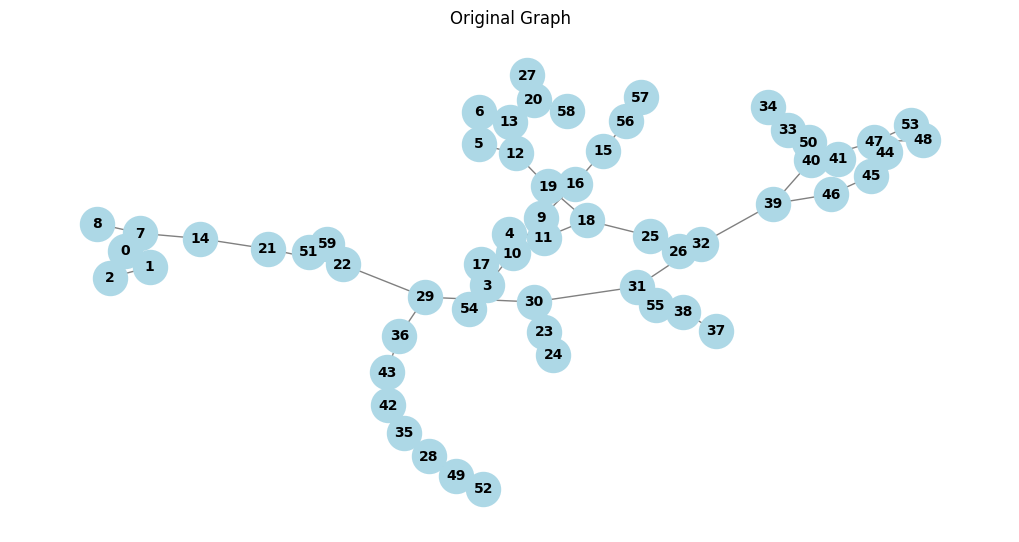

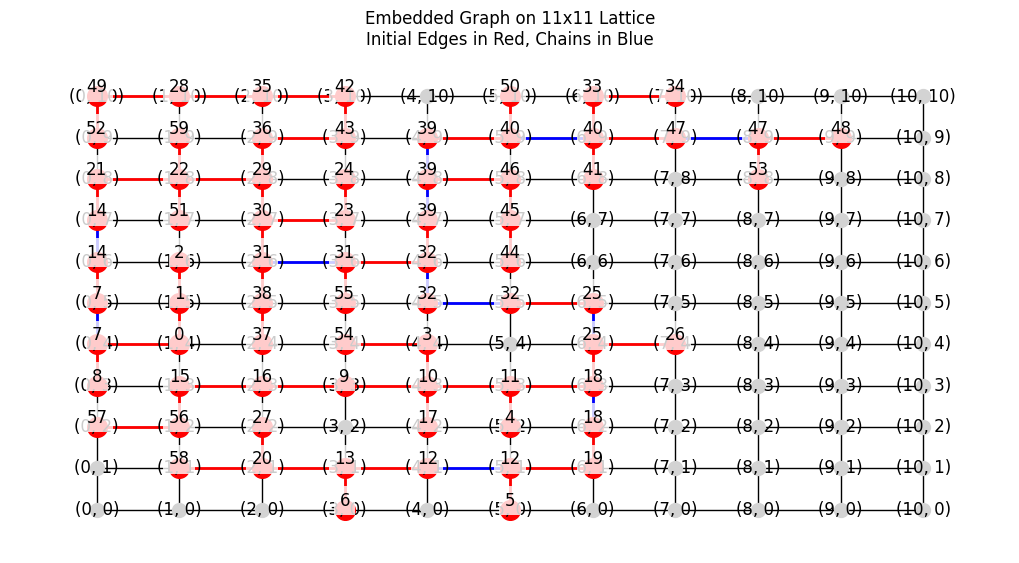

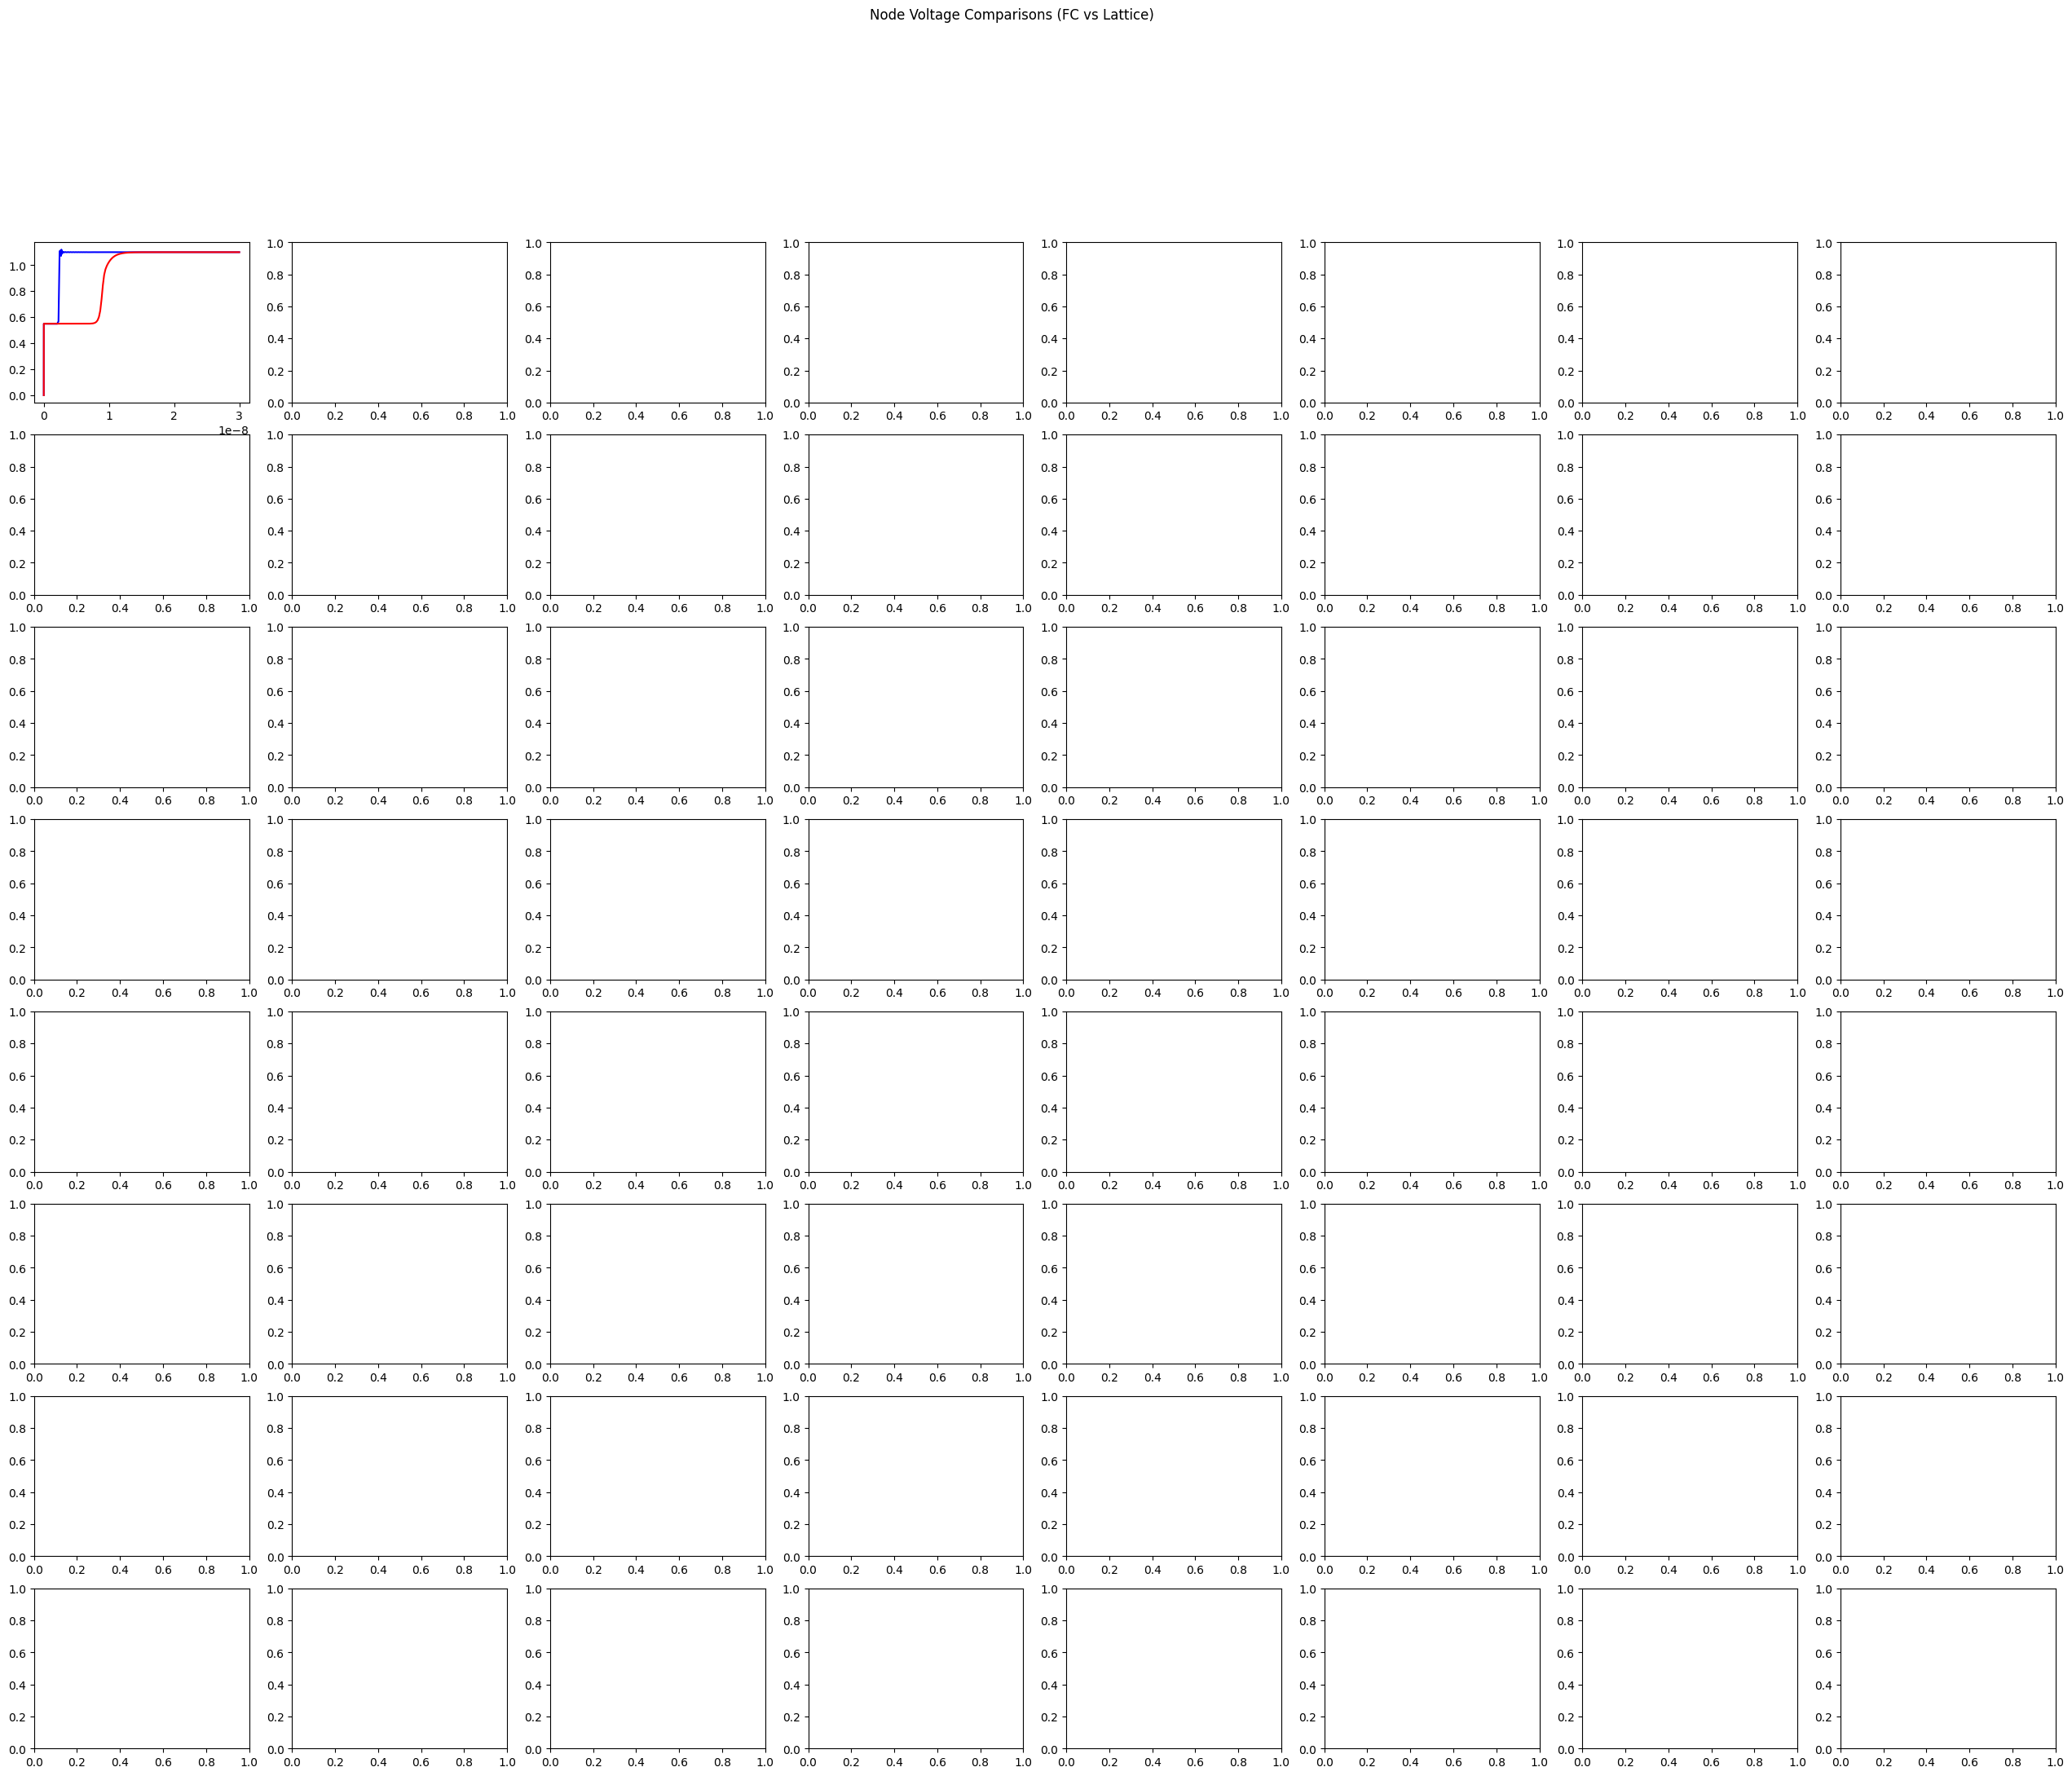

In [ ]:
def find_unit_edges(points):
    edges = []
    for p1, p2 in combinations(points, 2):
        if np.linalg.norm(np.array(p1) - np.array(p2)) == 1:
            edges.append((p1, p2))
    return edges

def plot_node_comparisons(num_nodes):
    """Automatically create comparison plots for all nodes in a grid layout, including OpenJIJ results."""
    try:
        # Read both CSV files
        df_fc = pd.read_csv("AutomatedfcIsing.csv", sep='\s+', header=None, skipinitialspace=True)
        df_lattice = pd.read_csv("AutomatedlatticeIsing.csv", sep='\s+', header=None, skipinitialspace=True)
        df_lattice_cap2 = pd.read_csv("AutomatedLatticeIsingCap2.csv", sep='\s+', header=None, skipinitialspace=True)
        df_lattice_cap5 = pd.read_csv("AutomatedLatticeIsingCap5.csv", sep='\s+', header=None, skipinitialspace=True)
        df_lattice_cap10 = pd.read_csv("AutomatedLatticeIsingCap10.csv", sep='\s+', header=None, skipinitialspace=True)
        # Get voltage data (every second column starting from index 1)
        voltages_fc = df_fc.iloc[:, 1::2]
        voltages_lattice = df_lattice.iloc[:, 1::2]
        voltages_lattice_cap2 = df_lattice_cap2.iloc[:, 1::2]
        voltages_lattice_cap5 = df_lattice_cap5.iloc[:, 1::2]
        voltages_lattice_cap10 = df_lattice_cap10.iloc[:, 1::2]
        # Get time data
        time_fc = df_fc.iloc[:, 0]
        time_lattice = df_lattice.iloc[:, 0]
        time_lattice_cap2 = df_lattice.iloc[:, 0]
        time_lattice_cap5 = df_lattice.iloc[:, 0]
        time_lattice_cap10 = df_lattice.iloc[:, 0]
        # Calculate grid dimensions (square-ish layout)
        cols = math.ceil(math.sqrt(num_nodes))
        rows = math.ceil(num_nodes / cols)

        # Create figure
        fig, axs = plt.subplots(rows, cols, figsize=(cols*4, rows*3))
        fig.suptitle('Node Voltage Comparisons (FC vs Lattice)', fontsize=12, y=1)

        # Flatten axes array for easy iteration
        if num_nodes > 1:
            axs = axs.flatten()
        else:
            axs = [axs]  # Make it iterable for single node case

        # Plot each node comparison
        for i in range(num_nodes):
            ax = axs[i]
            ax.plot(time_fc, voltages_fc.iloc[:, i+2], color="blue", label='FC')
            ax.plot(time_lattice, voltages_lattice.iloc[:, i+2], color="red", label='Lattice')
            ax.plot(time_lattice_cap2, voltages_lattice_cap2.iloc[:, i+2], color="green", label='Lattice with Intra-Spin Cap = 2')
            ax.plot(time_lattice_cap5, voltages_lattice_cap5.iloc[:, i+2], color="orange", label='Lattice with Intra-Spin Cap = 5')
            ax.plot(time_lattice_cap10, voltages_lattice_cap10.iloc[:, i+2], color="purple", label='Lattice with Intra-Spin Cap = 10')
            # # Add OpenJIJ results as a horizontal line (assuming ±1 Ising values map to voltage)
            # openjij_voltage = best_sample[i]  # OpenJIJ spin value (-1 or 1)
            # ax.axhline(y=openjij_voltage, color='red', linestyle='--', label='OpenJIJ')

            ax.set_title(f'Node Q{i+1}')
            ax.set_xlabel('Time (s)')
            ax.set_ylabel('Voltage (V)')
            ax.grid(True)
            ax.legend()

        # Hide unused subplots
        for j in range(num_nodes, len(axs)):
            axs[j].axis('off')

        plt.tight_layout()

    except Exception as e:
        print(f"Error plotting results: {str(e)}")

num_nodes = 60
sparsity = 0.0983
cap_values_femto = 200

# Create graph
# G = nx.erdos_renyi_graph(num_nodes, sparsity)
G = generate_graph_with_sparsity(num_nodes, sparsity)
print("k=", sparsity*(num_nodes-1))
lattice_size, square_lattice, embedding = find_minimum_lattice_size(G)

# Generate netlists
fc_netlist = generate_spice_netlist(G, embedding, cap_values_femto, graph='fc')
with open(r"/content/AutomatedfcIsing.cir", "w") as f:
    f.write(fc_netlist)
print("SPICE netlist generated: AutomatedFCIsing.cir")

lattice_netlist = generate_spice_netlist(G, embedding, cap_values_femto, graph='lattice')
with open(r"/content/AutomatedlatticeIsing.cir", "w") as f:
    f.write(lattice_netlist)
print("SPICE netlist generated: AutomatedLatticeIsing.cir")

lattice_cap2_netlist = generate_spice_netlist(G, embedding, cap_values_femto, graph='latticecap2')
with open(r"/content/AutomatedLatticeIsingCap2.cir", "w") as f:
    f.write(lattice_cap2_netlist)
print("SPICE netlist generated: AutomatedLatticeIsingCap2.cir")

lattice_cap5_netlist = generate_spice_netlist(G, embedding, cap_values_femto, graph='latticecap5')
with open(r"/content/AutomatedLatticeIsingCap5.cir", "w") as f:
    f.write(lattice_cap5_netlist)
print("SPICE netlist generated: AutomatedLatticeIsingCap5.cir")

lattice_cap10_netlist = generate_spice_netlist(G, embedding, cap_values_femto, graph='latticecap10')
with open(r"/content/AutomatedLatticeIsingCap10.cir", "w") as f:
    f.write(lattice_cap10_netlist)
print("SPICE netlist generated: AutomatedLatticeIsingCap10.cir")

# Analysis
physical_spins = set()
for chain in embedding.values():
    physical_spins.update(chain)
num_spins = len(physical_spins)

print("Minimum lattice size:", lattice_size, "x", lattice_size)
print("Number of physical spins used:", num_spins)
print("Embedding:", embedding)
print("Initial Edges:", G.edges())

# Visualization
plt.figure(figsize=(10, 5))
# plt.subplot(121)
pos_G = nx.spring_layout(G, seed=42)
nx.draw(G, pos_G, with_labels=True, node_color='lightblue', edge_color='gray', node_size=600, font_size=10, font_weight='bold')
plt.title("Original Graph")

plt.figure(figsize=(10, 5))
# plt.subplot(122)
pos = {(x, y): (x, y) for x, y in square_lattice.nodes()}
nx.draw(square_lattice, pos, node_size=100, node_color='lightgray', with_labels=True)

for node, chain in embedding.items():
    for qubit in chain:
        nx.draw_networkx_nodes(square_lattice, pos, nodelist=[qubit], node_color='red', node_size=200)
    for edge in find_unit_edges(chain):
        nx.draw_networkx_edges(square_lattice, pos, edgelist=[edge], edge_color='blue', width=2)

for node, chain in embedding.items():
    for qubit in chain:
        plt.text(
            pos[qubit][0], pos[qubit][1] + 0.1,
            f"{node}",
            horizontalalignment='center',
            color='black',
            fontsize=12,
            bbox=dict(facecolor='white', edgecolor='none', alpha=0.8))
plt.title(f"Embedded Graph on {lattice_size}x{lattice_size} Lattice\n"
            f"Initial Edges in Red, Chains in Blue")

for u, v in G.edges():
    chain_u = embedding[u]
    chain_v = embedding[v]
    qubit_u = chain_u[-1]
    qubit_v = chain_v[-1]
    if (qubit_u[0] == qubit_v[0] and abs(qubit_u[1]-qubit_v[1]) == 1) or (qubit_u[1] == qubit_v[1] and abs(qubit_u[0]-qubit_v[0]) == 1):
        nx.draw_networkx_edges(
            square_lattice, pos,
            edgelist=[(qubit_u, qubit_v)],
            edge_color='red',
            width=2
        )
    else:
        for i_qubit in chain_u[::-1]:
            for j_qubit in chain_v[::-1]:
                if (i_qubit[0] == j_qubit[0] and abs(i_qubit[1]-j_qubit[1]) == 1) or (i_qubit[1] == j_qubit[1] and abs(i_qubit[0]-j_qubit[0]) == 1):
                    nx.draw_networkx_edges(
                        square_lattice, pos,
                        edgelist=[(i_qubit, j_qubit)],
                        edge_color='red',
                        width=2
                    )
                    break
            else:
                continue
            break
# Run simulations
run_ngspice_colab(r"/content/AutomatedfcIsing.cir")
run_ngspice_colab(r"/content/AutomatedlatticeIsing.cir")
run_ngspice_colab(r"/content/AutomatedLatticeIsingCap2.cir")
run_ngspice_colab(r"/content/AutomatedLatticeIsingCap5.cir")
run_ngspice_colab(r"/content/AutomatedLatticeIsingCap10.cir")
H_bm = solve_ising_problem(G)
plot_node_comparisons(num_nodes)
H_fc = compute_hamiltonian("AutomatedfcIsing.csv", G.edges(), cap_values_femto, graph="fc")
H_lattice= compute_hamiltonian("AutomatedlatticeIsing.csv", G.edges(), cap_values_femto, graph="lattice", embedding=embedding)
H_lattice_cap2 = compute_hamiltonian("AutomatedLatticeIsingCap2.csv", G.edges(), cap_values_femto, graph="latticecap2", embedding=embedding)
H_lattice_cap5 = compute_hamiltonian("AutomatedLatticeIsingCap5.csv", G.edges(), cap_values_femto, graph="latticecap5", embedding=embedding)
H_lattice_cap10 = compute_hamiltonian("AutomatedLatticeIsingCap10.csv", G.edges(), cap_values_femto, graph="latticecap10", embedding=embedding)
print("Hamiltonian (FC):", H_fc[0])
print("Hamiltonian (Lattice):", H_lattice[0])
print("Hamiltonian (Lattice with Intra-Spin Cap = 2):", H_lattice_cap2[0])
print("Hamiltonian (Lattice with Intra-Spin Cap = 5):", H_lattice_cap5[0])
print("Hamiltonian (Lattice with Intra-Spin Cap = 10):", H_lattice_cap10[0])
print("Hamiltonian (Benchmark):", H_bm)

print("First exceed time (FC):", H_fc[1])
print("First exceed time (Lattice):", H_lattice[1])
print("First exceed time (Lattice with Intra-Spin Cap = 2):", H_lattice_cap2[1])
print("First exceed time (Lattice with Intra-Spin Cap = 5):", H_lattice_cap5[1])
print("First exceed time (Lattice with Intra-Spin Cap = 10):", H_lattice_cap10[1])
if H_fc[0] == H_bm:
    print("✅ FC Hamiltonian matches benchmark results!")
else:
    print("❌ FC Hamiltonian does not match benchmark results.")

if H_lattice[0] == H_bm:
    print("✅ Lattice Hamiltonian matches benchmark results!")
else:
    print("❌ Lattice Hamiltonian does not match benchmark results.")

if H_lattice_cap2[0] == H_bm:
    print("✅ Lattice with Cap = 2 Hamiltonian matches benchmark results!")
else:
    print("❌ Lattice with Cap = 2 Hamiltonian does not match benchmark results.")

if H_lattice_cap5[0] == H_bm:
    print("✅ Lattice with Cap = 5 Hamiltonian matches benchmark results!")
else:
    print("❌ Lattice with Cap = 5 Hamiltonian does not match benchmark results.")

if H_lattice_cap10[0] == H_bm:
    print("✅ Lattice with Cap = 10 Hamiltonian matches benchmark results!")
else:
    print("❌ Lattice with Cap = 10 Hamiltonian does not match benchmark results.")
plt.show()

In [ ]:
def check_effective_sparsity():
    node_sizes = [10, 20, 30, 40, 50, 60]
    sparsity_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

    print("Effective Sparsity Checker")
    print("="*50)
    print("This shows the actual edge probabilities being used\n")

    for num_nodes in node_sizes:
        max_edges_planar = 3 * num_nodes - 6
        max_possible_edges = num_nodes * (num_nodes - 1) / 2
        max_sparsity = max_edges_planar / max_possible_edges

        print(f"\nNode size: {num_nodes}")
        print(f"- Max possible edges: {int(max_possible_edges)}")
        print(f"- Planar graph limit: {max_edges_planar} edges ({max_sparsity:.4f} sparsity)")
        print("\nRequested sparsities:")

        for sparsity in sparsity_values:
            effective_sparsity = sparsity * max_sparsity
            avg_edges = effective_sparsity * max_possible_edges
            k = effective_sparsity * (num_nodes-1)
            warning = ""
            if effective_sparsity < 0.01:
                warning = "⚠️ VERY LOW - likely empty graphs"
            elif effective_sparsity < 0.05:
                warning = "⚠️ Low - might get empty graphs"

            print(f"  {sparsity:.1f} * {max_sparsity:.4f} = {effective_sparsity:.4f} → ~{avg_edges:.1f} edges, k = {k:.4f} {warning}")

if __name__ == "__main__":
    check_effective_sparsity()

Effective Sparsity Checker
This shows the actual edge probabilities being used


Node size: 10
- Max possible edges: 45
- Planar graph limit: 24 edges (0.5333 sparsity)

Requested sparsities:
  0.1 * 0.5333 = 0.0533 → ~2.4 edges, k = 0.4800 
  0.2 * 0.5333 = 0.1067 → ~4.8 edges, k = 0.9600 
  0.3 * 0.5333 = 0.1600 → ~7.2 edges, k = 1.4400 
  0.4 * 0.5333 = 0.2133 → ~9.6 edges, k = 1.9200 
  0.5 * 0.5333 = 0.2667 → ~12.0 edges, k = 2.4000 
  0.6 * 0.5333 = 0.3200 → ~14.4 edges, k = 2.8800 
  0.7 * 0.5333 = 0.3733 → ~16.8 edges, k = 3.3600 
  0.8 * 0.5333 = 0.4267 → ~19.2 edges, k = 3.8400 
  0.9 * 0.5333 = 0.4800 → ~21.6 edges, k = 4.3200 
  1.0 * 0.5333 = 0.5333 → ~24.0 edges, k = 4.8000 

Node size: 20
- Max possible edges: 190
- Planar graph limit: 54 edges (0.2842 sparsity)

Requested sparsities:
  0.1 * 0.2842 = 0.0284 → ~5.4 edges, k = 0.5400 ⚠️ Low - might get empty graphs
  0.2 * 0.2842 = 0.0568 → ~10.8 edges, k = 1.0800 
  0.3 * 0.2842 = 0.0853 → ~16.2 edges, k = 1.6200 
  0.4 

# **8) MAIN: Takes most of the time**

In [ ]:
num_tests_per_point = 50
capacitance_values_sweep = np.array([200])
node_sizes_sweep = [10, 60]
sparsity_values_sweep = [1]
# Phase 1: Generate all test cases
generated_cases, valid_combos = generate_test_cases(
    node_sizes=node_sizes_sweep,
    sparsity_values=sparsity_values_sweep,
    num_tests=num_tests_per_point
)

--- Phase 1: Pre-generating and Embedding Test Cases ---


Node Size Sweep: 100%|██████████| 2/2 [01:02<00:00, 31.40s/it]


--- Summary of Generated Test Cases ---
Nodes     Sparsity    Generated Cases          
--------------------------------------------------
10        1.00        50                       
60        1.00        50                       
✅ Saved 50 cases to saved_cases/N10_S1.00.txt
✅ Saved 50 cases to saved_cases/N60_S1.00.txt


In [ ]:
run_simulation_sweep(generated_cases, valid_combos, node_sizes_sweep, sparsity_values_sweep, capacitance_values_sweep, ["fc"])


--- Phase 2: Starting SPICE Simulation Sweep ---


Simulating N=10, S=1.00, C=200fF:   2%|▏         | 1/50 [00:00<00:05,  9.24it/s]

Partition: ({1, 3, 5, 6, 8}, {0, 2, 4, 7, 9})
[-1, 1, -1, 1, -1, 1, 1, -1, 1, -1]
Partition: ({0, 1, 5, 6, 7, 9}, {8, 2, 3, 4})
[1, 1, -1, -1, -1, 1, 1, 1, -1, 1]



Simulating N=10, S=1.00, C=200fF:   6%|▌         | 3/50 [00:00<00:03, 13.00it/s]

Partition: ({1, 2, 3, 7, 9}, {0, 4, 5, 6, 8})
[-1, 1, 1, 1, -1, -1, -1, 1, -1, 1]
Partition: ({1, 3, 5, 7, 9}, {0, 2, 4, 6, 8})
[-1, 1, -1, 1, -1, 1, -1, 1, -1, 1]



Simulating N=10, S=1.00, C=200fF:  10%|█         | 5/50 [00:00<00:02, 15.61it/s]

Partition: ({1, 2, 3, 7, 8}, {0, 4, 5, 6, 9})
[-1, 1, 1, 1, -1, -1, -1, 1, 1, -1]
Partition: ({2, 3, 4, 8, 9}, {0, 1, 5, 6, 7})
[-1, -1, 1, 1, 1, -1, -1, -1, 1, 1]



Simulating N=10, S=1.00, C=200fF:  14%|█▍        | 7/50 [00:00<00:02, 16.51it/s]

Partition: ({0, 1, 5, 6, 7}, {2, 3, 4, 8, 9})
[1, 1, -1, -1, -1, 1, 1, 1, -1, -1]
Partition: ({1, 3, 5, 7, 9}, {0, 2, 4, 6, 8})
[-1, 1, -1, 1, -1, 1, -1, 1, -1, 1]



Simulating N=10, S=1.00, C=200fF:  20%|██        | 10/50 [00:00<00:02, 19.41it/s]

Partition: ({8, 2, 4, 6}, {0, 1, 3, 5, 7, 9})
[-1, -1, 1, -1, 1, -1, 1, -1, 1, -1]
Partition: ({0, 2, 3, 4, 7}, {1, 5, 6, 8, 9})
[1, -1, 1, 1, 1, -1, -1, 1, -1, -1]
Partition: ({1, 5, 6, 9}, {0, 2, 3, 4, 7, 8})
[-1, 1, -1, -1, -1, 1, 1, -1, -1, 1]
Partition: ({1, 3, 6, 8, 9}, {0, 2, 4, 5, 7})
[-1, 1, -1, 1, -1, -1, 1, -1, 1, 1]



Simulating N=10, S=1.00, C=200fF:  26%|██▌       | 13/50 [00:00<00:01, 20.98it/s]

Partition: ({1, 5, 6}, {0, 2, 3, 4, 7, 8, 9})
[-1, 1, -1, -1, -1, 1, 1, -1, -1, -1]
Partition: ({0, 1, 5, 7, 9}, {2, 3, 4, 6, 8})
[1, 1, -1, -1, -1, 1, -1, 1, -1, 1]
Partition: ({0, 1, 5, 6, 7}, {2, 3, 4, 8, 9})
[1, 1, -1, -1, -1, 1, 1, 1, -1, -1]



Simulating N=10, S=1.00, C=200fF:  32%|███▏      | 16/50 [00:00<00:01, 20.56it/s]

Partition: ({0, 1, 5, 6, 7}, {2, 3, 4, 8, 9})
[1, 1, -1, -1, -1, 1, 1, 1, -1, -1]
Partition: ({0, 9, 5, 7}, {1, 2, 3, 4, 6, 8})
[1, -1, -1, -1, -1, 1, -1, 1, -1, 1]
Partition: ({0, 2, 5, 7, 9}, {1, 3, 4, 6, 8})
[1, -1, 1, -1, -1, 1, -1, 1, -1, 1]



Simulating N=10, S=1.00, C=200fF:  38%|███▊      | 19/50 [00:00<00:01, 20.82it/s]

Partition: ({0, 2, 3, 5, 7, 9}, {8, 1, 4, 6})
[1, -1, 1, 1, -1, 1, -1, 1, -1, 1]
Partition: ({1, 3, 5, 7, 9}, {0, 2, 4, 6, 8})
[-1, 1, -1, 1, -1, 1, -1, 1, -1, 1]
Partition: ({1, 3, 5, 6, 8, 9}, {0, 2, 4, 7})
[-1, 1, -1, 1, -1, 1, 1, -1, 1, 1]



Simulating N=10, S=1.00, C=200fF:  44%|████▍     | 22/50 [00:01<00:01, 17.58it/s]

Partition: ({1, 3, 5, 7}, {0, 2, 4, 6, 8, 9})
[-1, 1, -1, 1, -1, 1, -1, 1, -1, -1]
Partition: ({0, 4, 5, 6, 9}, {1, 2, 3, 7, 8})
[1, -1, -1, -1, 1, 1, 1, -1, -1, 1]



Simulating N=10, S=1.00, C=200fF:  48%|████▊     | 24/50 [00:01<00:01, 17.03it/s]

Partition: ({0, 1, 5, 6, 7, 9}, {8, 2, 3, 4})
[1, 1, -1, -1, -1, 1, 1, 1, -1, 1]
Partition: ({0, 1, 5, 6, 7, 9}, {8, 2, 3, 4})
[1, 1, -1, -1, -1, 1, 1, 1, -1, 1]



Simulating N=10, S=1.00, C=200fF:  52%|█████▏    | 26/50 [00:01<00:01, 17.66it/s]

Partition: ({0, 2, 4, 6, 8, 9}, {1, 3, 5, 7})
[1, -1, 1, -1, 1, -1, 1, -1, 1, 1]
Partition: ({1, 3, 5, 7}, {0, 2, 4, 6, 8, 9})
[-1, 1, -1, 1, -1, 1, -1, 1, -1, -1]



Simulating N=10, S=1.00, C=200fF:  56%|█████▌    | 28/50 [00:01<00:01, 17.77it/s]

Partition: ({0, 2, 3, 5, 7}, {1, 4, 6, 8, 9})
[1, -1, 1, 1, -1, 1, -1, 1, -1, -1]
Partition: ({1, 3, 5, 7, 9}, {0, 2, 4, 6, 8})
[-1, 1, -1, 1, -1, 1, -1, 1, -1, 1]



Simulating N=10, S=1.00, C=200fF:  60%|██████    | 30/50 [00:01<00:01, 18.27it/s]

Partition: ({0, 4, 5, 6, 9}, {1, 2, 3, 7, 8})
[1, -1, -1, -1, 1, 1, 1, -1, -1, 1]
Partition: ({0, 1, 5, 6, 7}, {2, 3, 4, 8, 9})
[1, 1, -1, -1, -1, 1, 1, 1, -1, -1]



Simulating N=10, S=1.00, C=200fF:  64%|██████▍   | 32/50 [00:01<00:00, 18.52it/s]

Partition: ({0, 2, 4, 6, 8}, {1, 3, 5, 7, 9})
[1, -1, 1, -1, 1, -1, 1, -1, 1, -1]
Partition: ({1, 3, 5, 6, 8}, {0, 2, 4, 7, 9})
[-1, 1, -1, 1, -1, 1, 1, -1, 1, -1]



Simulating N=10, S=1.00, C=200fF:  68%|██████▊   | 34/50 [00:01<00:00, 18.78it/s]

Partition: ({1, 3, 5, 7, 9}, {0, 2, 4, 6, 8})
[-1, 1, -1, 1, -1, 1, -1, 1, -1, 1]
Partition: ({1, 3, 6, 8, 9}, {0, 2, 4, 5, 7})
[-1, 1, -1, 1, -1, -1, 1, -1, 1, 1]
Partition: ({1, 4, 5, 6, 8, 9}, {0, 2, 3, 7})
[-1, 1, -1, -1, 1, 1, 1, -1, 1, 1]



Simulating N=10, S=1.00, C=200fF:  74%|███████▍  | 37/50 [00:02<00:00, 19.50it/s]

Partition: ({0, 1, 5, 6, 9}, {2, 3, 4, 7, 8})
[1, 1, -1, -1, -1, 1, 1, -1, -1, 1]
Partition: ({8, 1, 4, 6}, {0, 2, 3, 5, 7, 9})
[-1, 1, -1, -1, 1, -1, 1, -1, 1, -1]



Simulating N=10, S=1.00, C=200fF:  78%|███████▊  | 39/50 [00:02<00:00, 19.19it/s]

Partition: ({0, 2, 4, 6, 8, 9}, {1, 3, 5, 7})
[1, -1, 1, -1, 1, -1, 1, -1, 1, 1]
Partition: ({0, 2, 3, 5, 7, 9}, {8, 1, 4, 6})
[1, -1, 1, 1, -1, 1, -1, 1, -1, 1]



Simulating N=10, S=1.00, C=200fF:  82%|████████▏ | 41/50 [00:02<00:00, 17.41it/s]

Partition: ({0, 2, 3, 4, 7}, {1, 5, 6, 8, 9})
[1, -1, 1, 1, 1, -1, -1, 1, -1, -1]
Partition: ({0, 4, 5, 6, 9}, {1, 2, 3, 7, 8})
[1, -1, -1, -1, 1, 1, 1, -1, -1, 1]



Simulating N=10, S=1.00, C=200fF:  86%|████████▌ | 43/50 [00:02<00:00, 13.88it/s]

Partition: ({1, 3, 5, 7, 9}, {0, 2, 4, 6, 8})
[-1, 1, -1, 1, -1, 1, -1, 1, -1, 1]



Simulating N=10, S=1.00, C=200fF:  90%|█████████ | 45/50 [00:02<00:00, 14.25it/s]

Partition: ({0, 2, 4, 6, 8, 9}, {1, 3, 5, 7})
[1, -1, 1, -1, 1, -1, 1, -1, 1, 1]
Partition: ({2, 3, 4, 8, 9}, {0, 1, 5, 6, 7})
[-1, -1, 1, 1, 1, -1, -1, -1, 1, 1]
Partition: ({1, 3, 5, 7, 9}, {0, 2, 4, 6, 8})
[-1, 1, -1, 1, -1, 1, -1, 1, -1, 1]



Simulating N=10, S=1.00, C=200fF:  94%|█████████▍| 47/50 [00:02<00:00, 14.98it/s]

Partition: ({1, 3, 5, 6, 8}, {0, 2, 4, 7, 9})
[-1, 1, -1, 1, -1, 1, 1, -1, 1, -1]



Simulating N=10, S=1.00, C=200fF:  98%|█████████▊| 49/50 [00:02<00:00, 15.87it/s]
                                                                                 

Partition: ({0, 1, 5, 6, 7, 9}, {8, 2, 3, 4})
[1, 1, -1, -1, -1, 1, 1, 1, -1, 1]
Partition: ({8, 1, 5, 6}, {0, 2, 3, 4, 7, 9})
[-1, 1, -1, -1, -1, 1, 1, -1, 1, -1]
Partition: ({0, 2, 4, 5, 6}, {1, 3, 7, 8, 9})
[1, -1, 1, -1, 1, 1, 1, -1, -1, -1]



Simulating N=60, S=1.00, C=200fF:   2%|▏         | 1/50 [00:00<00:15,  3.10it/s]

Partition: ({1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 28, 29, 30, 31, 33, 36, 39, 41, 42, 44, 47, 52, 53, 55, 57}, {0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 32, 34, 35, 37, 38, 40, 43, 45, 46, 48, 49, 50, 51, 54, 56, 58, 59})
[-1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, 1, 1, 1, -1, 1, -1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, -1, -1, -1, 1, 1, -1, 1, -1, 1, -1, -1]



Simulating N=60, S=1.00, C=200fF:   4%|▍         | 2/50 [00:00<00:20,  2.34it/s]

Partition: ({1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 54, 55, 57, 58, 59}, {0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 51, 52, 53, 56})
[-1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, -1, -1, -1, 1, 1, -1, 1, 1, 1]



Simulating N=60, S=1.00, C=200fF:   6%|▌         | 3/50 [00:01<00:19,  2.46it/s]

Partition: ({1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 52, 53, 56, 59}, {0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 51, 54, 55, 57, 58})
[-1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, -1, -1, 1]



Simulating N=60, S=1.00, C=200fF:   8%|▊         | 4/50 [00:01<00:18,  2.52it/s]

Partition: ({0, 2, 4, 6, 8, 9, 11, 12, 14, 17, 18, 20, 21, 23, 25, 26, 29, 31, 33, 34, 35, 37, 39, 43, 45, 46, 48, 49, 50, 57, 59}, {1, 3, 5, 7, 10, 13, 15, 16, 19, 22, 24, 27, 28, 30, 32, 36, 38, 40, 41, 42, 44, 47, 51, 52, 53, 54, 55, 56, 58})
[1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, 1, 1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, 1, 1, -1, 1, -1, 1, -1, -1, -1, 1, -1, 1, 1, -1, 1, 1, 1, -1, -1, -1, -1, -1, -1, 1, -1, 1]



Simulating N=60, S=1.00, C=200fF:  10%|█         | 5/50 [00:02<00:18,  2.49it/s]

Partition: ({1, 3, 6, 7, 9, 11, 12, 15, 17, 19, 20, 21, 23, 25, 28, 30, 32, 33, 36, 38, 40, 41, 42, 44, 46, 51, 52, 53, 59}, {0, 2, 4, 5, 8, 10, 13, 14, 16, 18, 22, 24, 26, 27, 29, 31, 34, 35, 37, 39, 43, 45, 47, 48, 49, 50, 54, 55, 56, 57, 58})
[-1, 1, -1, 1, -1, -1, 1, 1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, 1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, 1, 1, -1, 1, -1, 1, -1, -1, -1, -1, 1, 1, 1, -1, -1, -1, -1, -1, 1]



Simulating N=60, S=1.00, C=200fF:  12%|█▏        | 6/50 [00:02<00:18,  2.40it/s]

Partition: ({1, 3, 5, 7, 8, 11, 12, 13, 15, 16, 18, 20, 21, 23, 25, 26, 28, 30, 34, 36, 37, 39, 40, 42, 43, 45, 48, 49, 50, 54, 55, 57}, {0, 2, 4, 6, 9, 10, 14, 17, 19, 22, 24, 27, 29, 31, 32, 33, 35, 38, 41, 44, 46, 47, 51, 52, 53, 56, 58, 59})
[-1, 1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, 1, 1, -1, 1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, -1, -1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, -1, -1, 1, 1, 1, -1, -1, -1, 1, 1, -1, 1, -1, -1]



Simulating N=60, S=1.00, C=200fF:  14%|█▍        | 7/50 [00:02<00:17,  2.52it/s]

Partition: ({1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 51, 53, 54, 55, 57, 58}, {0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 49, 50, 52, 56, 59})
[-1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, -1, -1, 1, -1, 1, 1, 1, -1, 1, 1, -1]



Simulating N=60, S=1.00, C=200fF:  16%|█▌        | 8/50 [00:03<00:17,  2.41it/s]

Partition: ({1, 4, 6, 7, 9, 12, 14, 16, 17, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 41, 42, 44, 46, 47, 50, 51, 53, 56, 59}, {0, 2, 3, 5, 8, 10, 11, 13, 15, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 40, 43, 45, 48, 49, 52, 54, 55, 57, 58})
[-1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, 1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, 1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, -1, -1, 1]



Simulating N=60, S=1.00, C=200fF:  18%|█▊        | 9/50 [00:03<00:15,  2.59it/s]

Partition: ({0, 3, 5, 6, 8, 9, 11, 12, 14, 15, 17, 18, 20, 21, 24, 25, 27, 30, 32, 33, 35, 36, 38, 41, 42, 44, 46, 47, 50, 52, 54, 55, 59}, {1, 2, 4, 7, 10, 13, 16, 19, 22, 23, 26, 28, 29, 31, 34, 37, 39, 40, 43, 45, 48, 49, 51, 53, 56, 57, 58})
[1, -1, -1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, -1, 1]



Simulating N=60, S=1.00, C=200fF:  20%|██        | 10/50 [00:04<00:16,  2.40it/s]

Partition: ({0, 2, 5, 8, 10, 12, 13, 14, 16, 18, 19, 22, 24, 26, 27, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 51, 55, 56, 57}, {1, 3, 4, 6, 7, 9, 11, 15, 17, 20, 21, 23, 25, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 50, 52, 53, 54, 58, 59})
[1, -1, 1, -1, -1, 1, -1, -1, 1, -1, 1, -1, 1, 1, 1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, 1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, -1, -1, 1, 1, 1, -1, -1]



Simulating N=60, S=1.00, C=200fF:  22%|██▏       | 11/50 [00:04<00:17,  2.26it/s]

Partition: ({1, 3, 5, 7, 10, 13, 15, 18, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 38, 39, 41, 43, 44, 46, 48, 50, 51, 52, 54, 57, 58}, {0, 2, 4, 6, 8, 9, 11, 12, 14, 16, 17, 20, 22, 24, 26, 28, 30, 32, 34, 36, 40, 42, 45, 47, 49, 53, 55, 56, 59})
[-1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, -1, 1, -1, 1, -1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, 1, 1, -1, 1, -1, -1, 1, 1, -1]



Simulating N=60, S=1.00, C=200fF:  24%|██▍       | 12/50 [00:05<00:17,  2.18it/s]

Partition: ({1, 4, 6, 7, 8, 9, 10, 12, 16, 18, 21, 24, 25, 27, 29, 30, 32, 33, 36, 38, 41, 42, 44, 47, 49, 50, 54, 55, 56, 58}, {0, 2, 3, 5, 11, 13, 14, 15, 17, 19, 20, 22, 23, 26, 28, 31, 34, 35, 37, 39, 40, 43, 45, 46, 48, 51, 52, 53, 57, 59})
[-1, 1, -1, -1, 1, -1, 1, 1, 1, 1, 1, -1, 1, -1, -1, -1, 1, -1, 1, -1, -1, 1, -1, -1, 1, 1, -1, 1, -1, 1, 1, -1, 1, 1, -1, -1, 1, -1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, -1, -1, 1, 1, 1, -1, 1, -1]



Simulating N=60, S=1.00, C=200fF:  26%|██▌       | 13/50 [00:05<00:15,  2.33it/s]

Partition: ({2, 4, 6, 7, 8, 10, 12, 15, 17, 18, 20, 21, 23, 25, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 52, 55, 57, 58, 59}, {0, 1, 3, 5, 9, 11, 13, 14, 16, 19, 22, 24, 26, 27, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 51, 53, 54, 56})
[-1, -1, 1, -1, 1, -1, 1, 1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, 1, -1, 1, -1, 1, -1, -1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, -1, 1, -1, 1, 1, 1]



Simulating N=60, S=1.00, C=200fF:  28%|██▊       | 14/50 [00:06<00:20,  1.78it/s]

Partition: ({1, 3, 4, 6, 7, 9, 12, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 35, 40, 41, 43, 45, 47, 51, 55, 56, 59}, {0, 2, 5, 8, 10, 11, 13, 14, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 36, 37, 38, 39, 42, 44, 46, 48, 49, 50, 52, 53, 54, 57, 58})
[-1, 1, -1, 1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, -1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, -1, -1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, -1, -1, 1, -1, -1, -1, 1, 1, -1, -1, 1]



Simulating N=60, S=1.00, C=200fF:  30%|███       | 15/50 [00:07<00:21,  1.65it/s]

Partition: ({1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 50, 52, 53, 54, 56, 57}, {0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 51, 55, 58, 59})
[-1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, 1, 1, -1, 1, 1, -1, -1]



Simulating N=60, S=1.00, C=200fF:  32%|███▏      | 16/50 [00:07<00:21,  1.61it/s]

Partition: ({1, 3, 5, 8, 10, 11, 13, 14, 16, 18, 19, 22, 24, 27, 28, 30, 32, 36, 38, 40, 42, 44, 46, 48, 50, 52, 57, 58, 59}, {0, 2, 4, 6, 7, 9, 12, 15, 17, 20, 21, 23, 25, 26, 29, 31, 33, 34, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 54, 55, 56})
[-1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, 1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, -1, -1, 1, 1, -1, 1, -1, 1, -1, -1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, -1, -1, -1, 1, 1, 1]



Simulating N=60, S=1.00, C=200fF:  34%|███▍      | 17/50 [00:08<00:19,  1.70it/s]

Partition: ({1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 40, 44, 46, 48, 49, 51, 54, 56, 58}, {0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 41, 42, 43, 45, 47, 50, 52, 53, 55, 57, 59})
[-1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, -1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, -1]



Simulating N=60, S=1.00, C=200fF:  36%|███▌      | 18/50 [00:08<00:18,  1.72it/s]

Partition: ({1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 28, 30, 31, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 53, 54, 55, 57, 58}, {0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 29, 32, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 56, 59})
[-1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, 1, 1, -1, 1, 1, -1]



Simulating N=60, S=1.00, C=200fF:  38%|███▊      | 19/50 [00:09<00:16,  1.83it/s]

Partition: ({1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 28, 29, 31, 34, 36, 38, 40, 42, 44, 46, 48, 49, 50, 52, 53, 55, 57, 58}, {0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 30, 32, 33, 35, 37, 39, 41, 43, 45, 47, 51, 54, 56, 59})
[-1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, 1, -1, 1, 1, -1, 1, -1, 1, 1, -1]



Simulating N=60, S=1.00, C=200fF:  40%|████      | 20/50 [00:09<00:14,  2.04it/s]

Partition: ({1, 3, 4, 6, 7, 9, 12, 15, 17, 18, 20, 21, 23, 25, 29, 30, 31, 33, 35, 36, 38, 39, 41, 43, 45, 47, 49, 50, 51, 56, 58}, {0, 2, 5, 8, 10, 11, 13, 14, 16, 19, 22, 24, 26, 27, 28, 32, 34, 37, 40, 42, 44, 46, 48, 52, 53, 54, 55, 57, 59})
[-1, 1, -1, 1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, 1, -1, 1, -1, 1, -1, -1, -1, 1, 1, 1, -1, 1, -1, 1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, 1, -1, -1, -1, -1, 1, -1, 1, -1]



Simulating N=60, S=1.00, C=200fF:  42%|████▏     | 21/50 [00:09<00:13,  2.12it/s]

Partition: ({1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 50, 52, 53, 54, 55, 58, 59}, {0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 51, 56, 57})
[-1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, 1, 1, 1, -1, -1, 1, 1]



Simulating N=60, S=1.00, C=200fF:  44%|████▍     | 22/50 [00:10<00:12,  2.24it/s]

Partition: ({0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 25, 28, 30, 34, 36, 37, 38, 39, 40, 43, 45, 48, 51, 52, 53, 54, 56, 58}, {1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 26, 27, 29, 31, 32, 33, 35, 41, 42, 44, 46, 47, 49, 50, 55, 57, 59})
[1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, -1, -1, -1, 1, -1, 1, 1, 1, 1, 1, -1, -1, 1, -1, 1, -1, -1, 1, -1, -1, 1, 1, 1, 1, -1, 1, -1, 1, -1]



Simulating N=60, S=1.00, C=200fF:  46%|████▌     | 23/50 [00:10<00:11,  2.26it/s]

Partition: ({1, 3, 5, 7, 9, 10, 12, 15, 17, 18, 20, 21, 22, 23, 26, 28, 30, 32, 34, 36, 38, 41, 42, 44, 46, 47, 49, 50, 51, 52, 59}, {0, 2, 4, 6, 8, 11, 13, 14, 16, 19, 24, 25, 27, 29, 31, 33, 35, 37, 39, 40, 43, 45, 48, 53, 54, 55, 56, 57, 58})
[-1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, 1, 1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, 1, -1, 1, -1, 1, 1, -1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, 1]



Simulating N=60, S=1.00, C=200fF:  48%|████▊     | 24/50 [00:11<00:15,  1.73it/s]

Partition: ({0, 2, 4, 6, 9, 11, 13, 15, 17, 19, 21, 23, 24, 25, 28, 29, 30, 32, 34, 37, 38, 40, 42, 44, 46, 48, 50, 51, 52, 56, 59}, {1, 3, 5, 7, 8, 10, 12, 14, 16, 18, 20, 22, 26, 27, 31, 33, 35, 36, 39, 41, 43, 45, 47, 49, 53, 54, 55, 57, 58})
[1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, 1, -1, -1, 1, 1, 1, -1, 1, -1, 1, -1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, 1, -1, -1, -1, 1, -1, -1, 1]



Simulating N=60, S=1.00, C=200fF:  50%|█████     | 25/50 [00:12<00:13,  1.87it/s]

Partition: ({0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 36, 38, 41, 42, 44, 47, 50, 51, 52, 54, 55, 56, 58}, {1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 34, 35, 37, 39, 40, 43, 45, 46, 48, 49, 53, 57, 59})
[1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, -1, -1, 1, -1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, 1, 1, 1, -1, 1, -1]



Simulating N=60, S=1.00, C=200fF:  52%|█████▏    | 26/50 [00:12<00:11,  2.09it/s]

Partition: ({1, 3, 5, 7, 9, 11, 13, 15, 17, 20, 21, 23, 24, 26, 28, 29, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 49, 50, 51, 54, 56, 58, 59}, {0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 19, 22, 25, 27, 31, 33, 35, 37, 39, 41, 43, 45, 47, 52, 53, 55, 57})
[-1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, 1, -1, 1, 1, -1, 1, -1, 1, 1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, 1, 1, -1, -1, 1, -1, 1, -1, 1, 1]



Simulating N=60, S=1.00, C=200fF:  54%|█████▍    | 27/50 [00:12<00:09,  2.32it/s]

Partition: ({1, 2, 4, 6, 7, 10, 12, 15, 16, 18, 20, 21, 24, 26, 29, 31, 32, 34, 35, 37, 40, 43, 45, 48, 51, 52, 55, 57, 58}, {0, 3, 5, 8, 9, 11, 13, 14, 17, 19, 22, 23, 25, 27, 28, 30, 33, 36, 38, 39, 41, 42, 44, 46, 47, 49, 50, 53, 54, 56, 59})
[-1, 1, 1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, -1, -1, 1, 1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, -1, 1, -1, 1, -1, -1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1]



Simulating N=60, S=1.00, C=200fF:  56%|█████▌    | 28/50 [00:13<00:08,  2.53it/s]

Partition: ({1, 3, 4, 6, 7, 9, 12, 15, 17, 18, 20, 21, 24, 26, 30, 33, 34, 36, 38, 39, 42, 44, 48, 49, 50, 52, 58, 59}, {0, 2, 5, 8, 10, 11, 13, 14, 16, 19, 22, 23, 25, 27, 28, 29, 31, 32, 35, 37, 40, 41, 43, 45, 46, 47, 51, 53, 54, 55, 56, 57})
[-1, 1, -1, 1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, 1, -1, -1, 1, -1, 1, -1, -1, -1, 1, -1, -1, 1, 1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, -1, -1, -1, 1, 1, 1, -1, 1, -1, -1, -1, -1, -1, 1, 1]



Simulating N=60, S=1.00, C=200fF:  58%|█████▊    | 29/50 [00:13<00:08,  2.42it/s]

Partition: ({0, 2, 5, 6, 8, 10, 11, 12, 14, 16, 18, 21, 22, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 50, 51, 53, 55, 57, 58}, {1, 3, 4, 7, 9, 13, 15, 17, 19, 20, 23, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 52, 54, 56, 59})
[1, -1, 1, -1, -1, 1, 1, -1, 1, -1, 1, 1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, 1, -1, 1, -1, 1, -1, 1, 1, -1]



Simulating N=60, S=1.00, C=200fF:  60%|██████    | 30/50 [00:14<00:08,  2.30it/s]

Partition: ({0, 2, 4, 6, 8, 10, 12, 14, 16, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 50, 52, 56, 57, 58}, {1, 3, 5, 7, 9, 11, 13, 15, 17, 18, 19, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 49, 51, 53, 54, 55, 59})
[1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, -1, -1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, -1, -1, -1, 1, 1, 1, -1]



Simulating N=60, S=1.00, C=200fF:  62%|██████▏   | 31/50 [00:14<00:08,  2.24it/s]

Partition: ({0, 2, 4, 6, 8, 10, 12, 14, 15, 18, 20, 23, 24, 26, 28, 32, 34, 36, 37, 38, 40, 42, 46, 48, 49, 50, 52, 55, 56, 57, 58, 59}, {1, 3, 5, 7, 9, 11, 13, 16, 17, 19, 21, 22, 25, 27, 29, 30, 31, 33, 35, 39, 41, 43, 44, 45, 47, 51, 53, 54})
[1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, -1, -1, 1, 1, -1, 1, -1, 1, -1, -1, -1, 1, -1, 1, -1, 1, 1, 1, -1, 1, -1, 1, -1, -1, -1, 1, -1, 1, 1, 1, -1, 1, -1, -1, 1, 1, 1, 1, 1]



Simulating N=60, S=1.00, C=200fF:  64%|██████▍   | 32/50 [00:15<00:09,  1.91it/s]

Partition: ({1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 25, 27, 28, 29, 30, 33, 38, 41, 42, 43, 45, 47, 49, 51, 53, 54, 55, 58, 59}, {0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 23, 24, 26, 31, 32, 34, 35, 36, 37, 39, 40, 44, 46, 48, 50, 52, 56, 57})
[-1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, -1, -1, 1, -1, 1, 1, 1, 1, -1, -1, 1, -1, -1, -1, -1, 1, -1, -1, 1, 1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, 1, -1, -1, 1, 1]



Simulating N=60, S=1.00, C=200fF:  66%|██████▌   | 33/50 [00:15<00:09,  1.82it/s]

Partition: ({0, 1, 3, 5, 8, 9, 11, 12, 13, 14, 16, 17, 20, 22, 26, 28, 30, 32, 34, 35, 36, 38, 40, 42, 44, 46, 48, 51, 53, 54, 55, 56, 57, 58, 59}, {2, 4, 6, 7, 10, 15, 18, 19, 21, 23, 24, 25, 27, 29, 31, 33, 37, 39, 41, 43, 45, 47, 49, 50, 52})
[1, 1, -1, 1, -1, 1, -1, -1, 1, 1, -1, 1, 1, 1, 1, -1, 1, 1, -1, -1, 1, -1, 1, -1, -1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1, 1, 1, 1, 1, 1]



Simulating N=60, S=1.00, C=200fF:  68%|██████▊   | 34/50 [00:16<00:08,  1.97it/s]

Partition: ({1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 51, 54, 56}, {0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 49, 50, 52, 53, 55, 57, 58, 59})
[-1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, -1, -1, 1, -1, -1, 1, -1, 1, -1, -1, -1]



Simulating N=60, S=1.00, C=200fF:  70%|███████   | 35/50 [00:16<00:06,  2.16it/s]

Partition: ({0, 2, 4, 5, 8, 10, 11, 13, 14, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 50, 51, 58}, {1, 3, 6, 7, 9, 12, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 49, 52, 53, 54, 55, 56, 57, 59})
[1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, 1, 1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, 1, -1, -1, -1, -1, -1, -1, 1, -1]



Simulating N=60, S=1.00, C=200fF:  72%|███████▏  | 36/50 [00:17<00:06,  2.23it/s]

Partition: ({1, 3, 5, 7, 9, 11, 13, 16, 17, 19, 21, 25, 27, 29, 31, 33, 35, 36, 38, 40, 42, 44, 47, 49, 50, 53, 54, 56, 59}, {0, 2, 4, 6, 8, 10, 12, 14, 15, 18, 20, 22, 23, 24, 26, 28, 30, 32, 34, 37, 39, 41, 43, 45, 46, 48, 51, 52, 55, 57, 58})
[-1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, 1, -1, 1, -1, 1, -1, -1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1]



Simulating N=60, S=1.00, C=200fF:  76%|███████▌  | 38/50 [00:17<00:03,  3.01it/s]

Partition: ({0, 2, 3, 5, 8, 11, 13, 14, 17, 19, 22, 25, 27, 28, 30, 31, 33, 39, 41, 43, 45, 47, 49, 50, 51, 52, 53, 56, 58, 59}, {1, 4, 6, 7, 9, 10, 12, 15, 16, 18, 20, 21, 23, 24, 26, 29, 32, 34, 35, 36, 37, 38, 40, 42, 44, 46, 48, 54, 55, 57})
[1, -1, 1, 1, -1, 1, -1, -1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, -1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, 1, -1, 1, -1, -1, -1, -1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, 1, 1, 1, -1, -1, 1, -1, 1, 1]
Partition: ({1, 4, 6, 7, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 49, 54, 55, 57, 59}, {0, 2, 3, 5, 8, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 50, 51, 52, 53, 56, 58})
[-1, 1, -1, -1, 1, -1, 1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, -1, -1, -1, 1, 1, -1, 1, -1, 1]



Simulating N=60, S=1.00, C=200fF:  78%|███████▊  | 39/50 [00:17<00:03,  3.51it/s]

Partition: ({0, 3, 5, 8, 9, 11, 13, 14, 15, 17, 19, 22, 23, 25, 27, 28, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 50, 51, 52, 57, 58}, {1, 2, 4, 6, 7, 10, 12, 16, 18, 20, 21, 24, 26, 29, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 53, 54, 55, 56, 59})
[1, -1, -1, 1, -1, 1, -1, -1, 1, 1, -1, 1, -1, 1, 1, 1, -1, 1, -1, 1, -1, -1, 1, 1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, 1, 1, -1, -1, -1, -1, 1, 1, -1]



Simulating N=60, S=1.00, C=200fF:  82%|████████▏ | 41/50 [00:18<00:02,  4.21it/s]

Partition: ({0, 2, 4, 6, 8, 9, 12, 13, 14, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 50, 51, 52, 53, 55, 58, 59}, {1, 3, 5, 7, 10, 11, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 54, 56, 57})
[1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, 1, 1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, 1, 1, 1, -1, 1, -1, -1, 1, 1]
Partition: ({1, 3, 4, 7, 9, 10, 12, 13, 14, 15, 18, 22, 23, 24, 27, 28, 29, 32, 33, 37, 38, 41, 42, 43, 46, 47, 50, 52, 54, 56, 58}, {0, 2, 5, 6, 8, 11, 16, 17, 19, 20, 21, 25, 26, 30, 31, 34, 35, 36, 39, 40, 44, 45, 48, 49, 51, 53, 55, 57, 59})
[-1, 1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, 1, 1, 1, 1, -1, -1, 1, -1, -1, -1, 1, 1, 1, -1, -1, 1, 1, 1, -1, -1, 1, 1, -1, -1, -1, 1, 1, -1, -1, 1, 1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1]



Simulating N=60, S=1.00, C=200fF:  86%|████████▌ | 43/50 [00:18<00:01,  4.73it/s]

Partition: ({0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 30, 32, 34, 35, 38, 43, 44, 46, 47, 49, 50, 51, 57}, {1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 28, 29, 31, 33, 36, 37, 39, 40, 41, 42, 45, 48, 52, 53, 54, 55, 56, 58, 59})
[1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, -1, -1, -1, -1, 1, 1, -1, 1, 1, -1, 1, 1, 1, -1, -1, -1, -1, -1, 1, -1, -1]
Partition: ({0, 2, 4, 6, 8, 10, 12, 13, 14, 16, 18, 22, 24, 27, 28, 31, 33, 36, 37, 39, 41, 42, 43, 45, 47, 49, 50, 52, 54, 57, 58}, {1, 3, 5, 7, 9, 11, 15, 17, 19, 20, 21, 23, 25, 26, 29, 30, 32, 34, 35, 38, 40, 44, 46, 48, 51, 53, 55, 56, 59})
[1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, 1, -1, 1, -1, 1, -1, -1, -1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, -1, -1, 1, 1, -1, 1, -1, 1, 1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, 1, -1]



Simulating N=60, S=1.00, C=200fF:  88%|████████▊ | 44/50 [00:18<00:01,  4.46it/s]

Partition: ({1, 3, 5, 7, 9, 11, 13, 14, 15, 17, 19, 22, 23, 25, 27, 28, 31, 33, 36, 39, 41, 42, 44, 47, 50, 53, 56, 58, 59}, {0, 2, 4, 6, 8, 10, 12, 16, 18, 20, 21, 24, 26, 29, 30, 32, 34, 35, 37, 38, 40, 43, 45, 46, 48, 49, 51, 52, 54, 55, 57})
[-1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, 1, -1, 1, -1, 1, -1, -1, 1, 1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, -1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, -1, 1, -1, -1, 1, -1, -1, 1, -1, 1, 1]



Simulating N=60, S=1.00, C=200fF:  90%|█████████ | 45/50 [00:18<00:01,  3.99it/s]

Partition: ({1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 44, 46, 50, 54, 55, 58}, {0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 45, 47, 48, 49, 51, 52, 53, 56, 57, 59})
[-1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, -1, -1, 1, -1, -1, -1, 1, 1, -1, -1, 1, -1]



Simulating N=60, S=1.00, C=200fF:  92%|█████████▏| 46/50 [00:19<00:01,  3.91it/s]

Partition: ({0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 33, 36, 38, 41, 42, 44, 47, 49, 52, 53, 57, 58}, {1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 34, 35, 37, 39, 40, 43, 45, 46, 48, 50, 51, 54, 55, 56, 59})
[1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, -1, -1, 1, 1, -1, -1, -1, 1, 1, -1]



Simulating N=60, S=1.00, C=200fF:  94%|█████████▍| 47/50 [00:19<00:00,  3.71it/s]

Partition: ({0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 29, 31, 34, 35, 37, 40, 43, 45, 46, 48, 49, 50, 51, 52, 57, 58}, {1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 28, 30, 32, 33, 36, 38, 39, 41, 42, 44, 47, 53, 54, 55, 56, 59})
[1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, 1, 1, 1, 1, -1, -1, -1, -1, 1, 1, -1]



Simulating N=60, S=1.00, C=200fF:  96%|█████████▌| 48/50 [00:19<00:00,  3.60it/s]

Partition: ({1, 3, 9, 12, 13, 14, 18, 22, 24, 26, 27, 30, 32, 33, 35, 37, 38, 41, 43, 44, 46, 47, 50, 55, 57}, {0, 2, 4, 5, 6, 7, 8, 10, 11, 15, 16, 17, 19, 20, 21, 23, 25, 28, 29, 31, 34, 36, 39, 40, 42, 45, 48, 49, 51, 52, 53, 54, 56, 58, 59})
[-1, 1, -1, 1, -1, -1, -1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, -1, 1, -1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, 1, 1, -1, -1, 1, -1, -1, -1, -1, 1, -1, 1, -1, -1]



Simulating N=60, S=1.00, C=200fF:  98%|█████████▊| 49/50 [00:20<00:00,  3.59it/s]

Partition: ({1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 53, 54, 56, 57, 58, 59}, {0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 49, 50, 51, 52, 55})
[-1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, -1, -1, -1, -1, 1, 1, -1, 1, 1, 1, 1]



Capacitance Sweep: 100%|██████████| 1/1 [00:23<00:00, 23.37s/it]

Partition: ({0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 25, 28, 30, 33, 34, 36, 38, 39, 42, 44, 46, 48, 49, 50, 54, 55, 57, 59}, {1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 24, 26, 27, 29, 31, 32, 35, 37, 40, 41, 43, 45, 47, 51, 52, 53, 56, 58})
[1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, -1, 1, -1, 1, -1, -1, 1, 1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, 1, 1, -1, -1, -1, 1, 1, -1, 1, -1, 1]


{'success_rates': {'fc': array([[[0.98]],
  
         [[0.18]]])},
 'convergence_times': {'fc': array([[[1.21950909e-08]],
  
         [[2.11009535e-09]]])},
 'energies': {'fc': array([[[3.24452050e-12]],
  
         [[3.40570826e-12]]])},
 'h_ratios': {'fc': array([[[0.73      ]],
  
         [[1.09795761]]])},
 'broken_chain_probs': {},
 'convergence_times_std': {'fc': array([[[2.31539155e-09]],
  
         [[4.81839189e-10]]])},
 'energies_std': {'fc': array([[[6.18873356e-13]],
  
         [[8.35238176e-13]]])},
 'h_ratios_std': {'fc': array([[[0.20787282]],
  
         [[0.08484329]]])},
 'capacitance_values': array([200]),
 'node_sizes': [10, 60],
 'sparsity_values': [1]}

In [ ]:
files.download("/content/sweep_results_latticecap10.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!zip -r /content/saved_cases.zip /content/saved_cases
files.download("/content/saved_cases.zip")

  adding: content/saved_cases/ (stored 0%)
  adding: content/saved_cases/N20_S0.80.txt (deflated 87%)
  adding: content/saved_cases/N50_S0.50.txt (deflated 85%)
  adding: content/saved_cases/N10_S0.40.txt (deflated 89%)
  adding: content/saved_cases/N10_S0.70.txt (deflated 89%)
  adding: content/saved_cases/N50_S1.00.txt (deflated 85%)
  adding: content/saved_cases/N50_S0.80.txt (deflated 85%)
  adding: content/saved_cases/N20_S0.50.txt (deflated 87%)
  adding: content/saved_cases/N50_S0.90.txt (deflated 85%)
  adding: content/saved_cases/N10_S0.10.txt (deflated 89%)
  adding: content/saved_cases/N20_S0.20.txt (deflated 87%)
  adding: content/saved_cases/N30_S0.30.txt (deflated 86%)
  adding: content/saved_cases/N40_S0.20.txt (deflated 85%)
  adding: content/saved_cases/N60_S0.10.txt (deflated 83%)
  adding: content/saved_cases/N50_S0.40.txt (deflated 85%)
  adding: content/saved_cases/N30_S1.00.txt (deflated 86%)
  adding: content/saved_cases/N40_S0.70.txt (deflated 85%)
  adding: con

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

def plot_metric_vs_sparsity(pickle_files, configs, metric, ylabel, ylim=None):
    """
    For each capacitance value, plot a metric vs sparsity for each N.
    One plot per capacitance, with a subplot for each config.
    """
    # Load all data
    data = {}
    for cfg in configs:
        with open(pickle_files[cfg], 'rb') as f:
            data[cfg] = pickle.load(f)

    # Common axis values
    node_sizes = data[configs[0]]['node_sizes']
    sparsity_values = data[configs[0]]['sparsity_values']
    cap_values = data[configs[0]]['capacitance_values']
    convergence_times = data[configs[0]]['convergence_times']
    # For each capacitance value, generate a figure
    for cap_idx, cap in enumerate(cap_values):
        fig, axes = plt.subplots(1, len(configs), figsize=(6 * len(configs), 5), sharey=True)
        if len(configs) == 1:
            axes = [axes]  # Ensure iterable if only one config

        fig.suptitle(f"{ylabel} vs r-Ratio (Capacitance = {cap} fF)", fontsize=14)

        for ax, cfg in zip(axes, configs):
            if metric not in data[cfg]:
                ax.set_visible(False)
                continue
            for n_idx, N in enumerate(node_sizes):
                y = data[cfg][metric][cfg][n_idx, :, cap_idx]
                ax.plot(sparsity_values, y, marker='o', label=f"N={N}")

            ax.set_title(cfg)
            ax.set_xlabel("gamma")
            if ylim:
                ax.set_ylim(*ylim)
            ax.grid(True, linestyle='--', alpha=0.6)
            if ax == axes[0]:
                ax.set_ylabel(ylabel)
            ax.legend()

        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()


# Example usage
pickle_files = {
    'fc': "sweep_results_fc.pkl",
    'lattice': "sweep_results_lattice.pkl",
    'latticecap2': "sweep_results_latticecap2.pkl",
    'latticecap5': "sweep_results_latticecap5.pkl",
    'latticecap10': "sweep_results_latticecap10.pkl"
}

configs_all = ['fc', 'lattice', 'latticecap2', 'latticecap5', 'latticecap10']
configs_latticecap = ['latticecap2', 'latticecap5', 'latticecap10']

# Plot success rates
plot_metric_vs_sparsity(
    pickle_files, configs_all,
    metric='success_rates', ylabel='Success Rate', ylim=(0, 1.05)
)

# Plot energies
plot_metric_vs_sparsity(
    pickle_files, configs_all,
    metric='energies', ylabel='Energy (J)'
)



# Plot probability of broken chains
plot_metric_vs_sparsity(
    pickle_files, configs_latticecap,
    metric='broken_chain_probs', ylabel='Broken Chain Probability', ylim=(0, 1.05)
)

# Plot probability of broken chains
plot_metric_vs_sparsity(
    pickle_files, configs_latticecap,
    metric='convergence_times', ylabel='Convergence Times', ylim=(0, 1.05)
)